# Sliding time window laminar model comparison using free energy

This tutorial demonstrates how to perform laminar inference of event-related responses in a sliding time window using model comparison based on free energy as a metric of model fit, described in [Bonaiuto et al., 2021, Laminar dynamics of high amplitude beta bursts in human motor cortex](https://doi.org/10.1016/j.neuroimage.2021.118479). A temporal Gaussian function is simulated at a particular cortical location in various layers. Source reconstruction is performed on the whole time window using the Empirical Bayesian Beamformer on the simulated sensor data using a forward model based on the multilayer mesh as a localizer. This is used to select priors on each layer mesh for a sliding time window model comparison using free energy.

## Setting up the simulations

Simulations are based on an existing dataset, which is used to define the sampling rate, number of trials, duration of each trial, and the channel layout.

In [1]:
import os
import shutil
import numpy as np
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt

from lameg.invert import coregister, invert_ebb, load_source_time_series
from lameg.laminar import sliding_window_model_comparison
from lameg.simulate import run_dipole_simulation
from lameg.surf import interpolate_data
from lameg.util import get_surface_names
from lameg.viz import show_surface, color_map
import spm_standalone

# Subject information for data to base the simulations on
subj_id = 'sub-104'
ses_id = 'ses-01'

# Fiducial coil coordinates
nas = [0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa = [-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa = [76.02110531729883, 18.9467849625573, -25.779407159603114]

# Data file to base simulations on
data_file = os.path.join(
    '../test_data', 
    subj_id, 
    'meg',
    ses_id, 
    'spm/pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'
)

spm = spm_standalone.initialize()

For source reconstructions, we need an MRI and a surface mesh. The simulations will be based on a forward model using the multilayer mesh, and the model comparison will use each layer mesh

In [2]:
# Native space MRI to use for coregistration
mri_fname = os.path.join('../test_data', subj_id, 'mri/s2023-02-28_13-33-133958-00001-00224-1.nii' )

# Mesh to use for forward model in the simulations
multilayer_mesh_fname = os.path.join('../test_data', subj_id, 'surf/multilayer.11.ds.link_vector.fixed.gii')

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Get name of each mesh that makes up the layers of the multilayer mesh - these will be used for the source 
# reconstruction
layer_fnames = get_surface_names(
    n_layers, 
    os.path.join('../test_data', subj_id, 'surf'), 
    'link_vector.fixed'
)

# Inflated meshes for plotting
ds_inflated = nib.load(os.path.join('../test_data', subj_id, 'surf', 'inflated.ds.gii'))
orig_inflated = nib.load(os.path.join('../test_data', subj_id, 'surf', 'inflated.gii'))

We're going to copy the data file to a temporary directory and direct all output there.

In [3]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/sliding_window'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

Invert the subject's data using the multilayer mesh. This step only has to be done once - this is just to compute the forward model that will be used in the simulations

In [4]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
24-Jul-2024 12:25:10 - Running job #1
------------------------------------------------------------------------
24-Jul-2024 12:25:10 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           12:25:10 - 24/07/2024
multilayer.11.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiome

## Simulating a signal on the pial surface
We're going to simulate 200ms of a Gaussian with a dipole moment of 5nAm and a width of 25ms

Text(0, 0.5, 'Amplitude (nAm)')

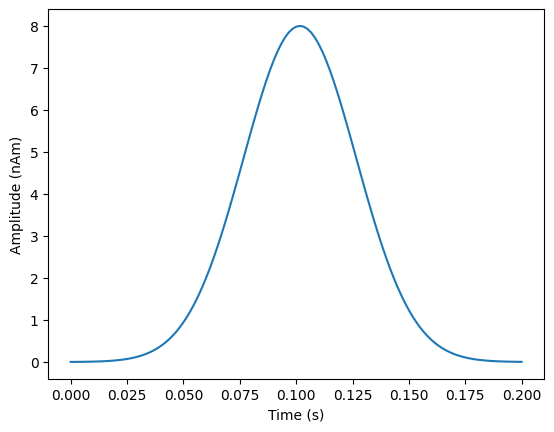

In [5]:
# Strength of simulated activity (nAm)
dipole_moment = 8
# Temporal width of the simulated Gaussian
signal_width=.025 # 25ms
# Sampling rate (must match the data file)
s_rate = 600

# Generate 200ms of a Gaussian at a sampling rate of 600Hz (to match the data file)
time=np.linspace(0,.2,121)
zero_time=time[int((len(time)-1)/2+1)]
sim_signal=np.exp(-((time-zero_time)**2)/(2*signal_width**2)).reshape(1,-1)
plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

We need to pick a location (mesh vertex) to simulate at

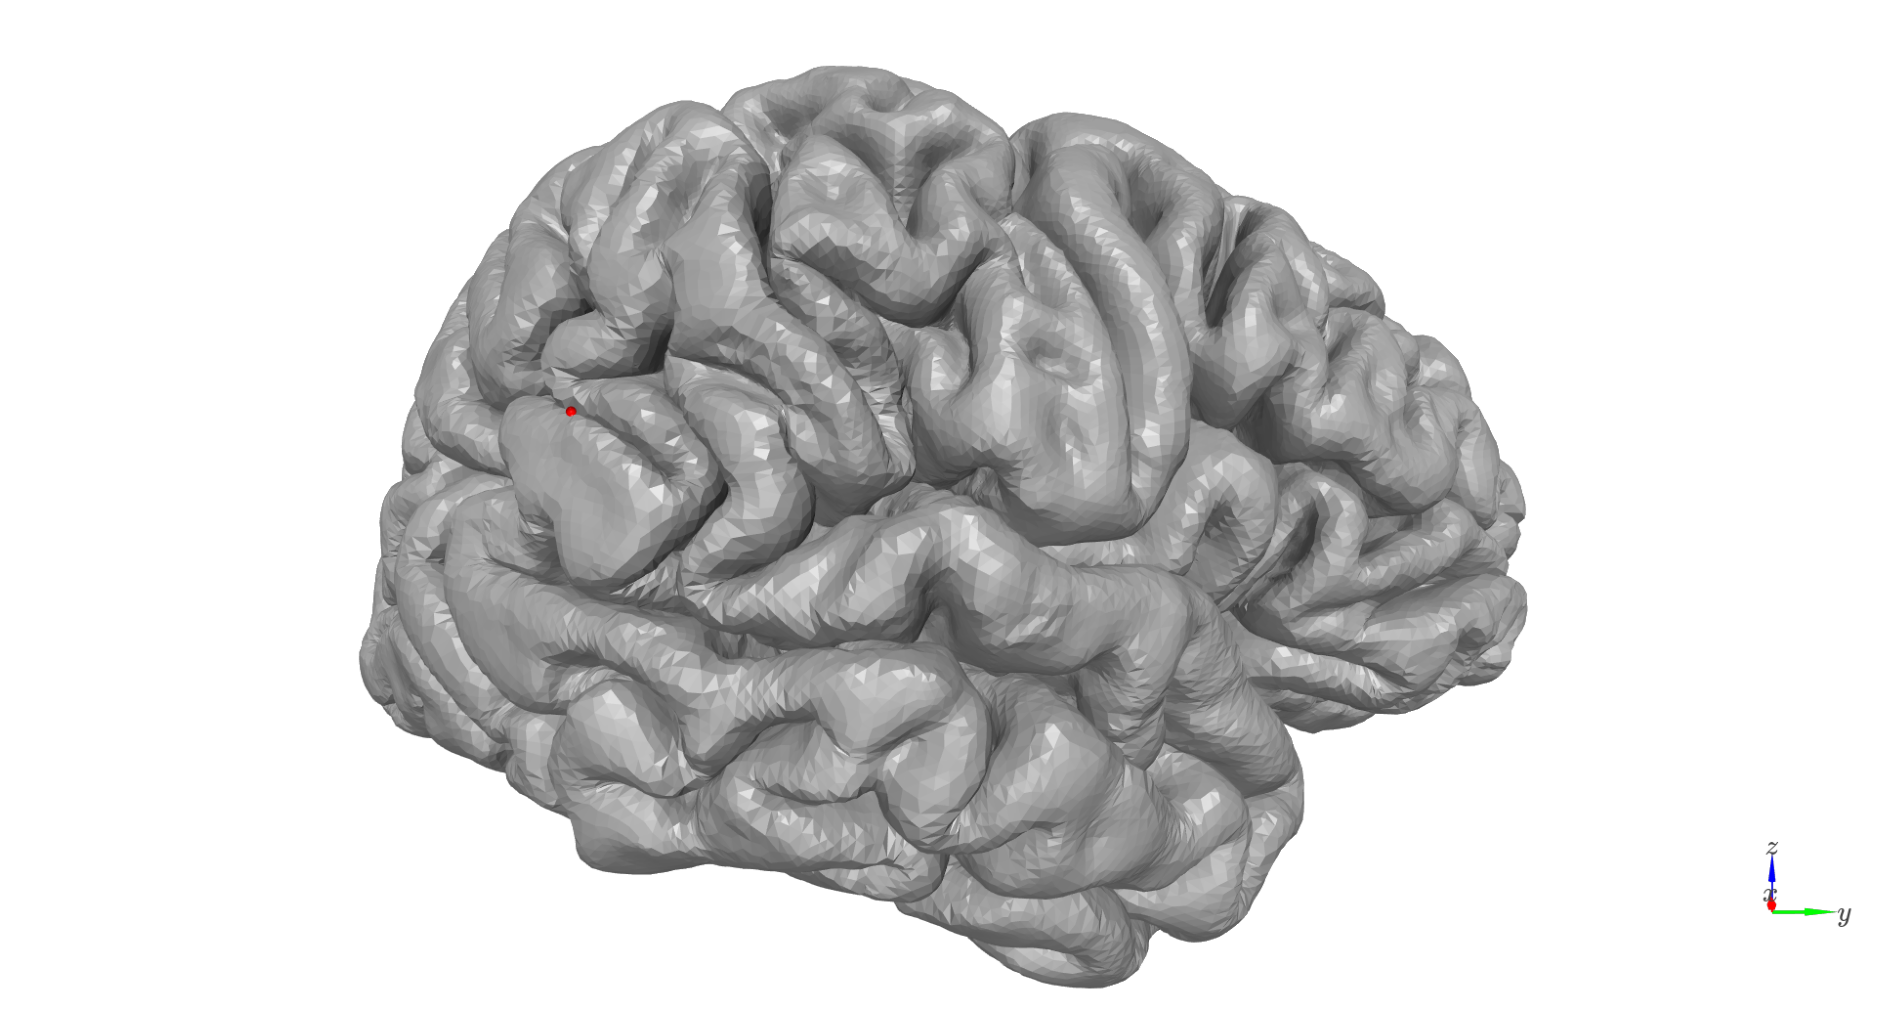

In [12]:
# Vertex to simulate activity at
sim_vertex=24585

pial_ds_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.ds.link_vector.fixed.gii')
pial_ds_mesh = nib.load(pial_ds_mesh_fname)
pial_coord = pial_ds_mesh.darrays[0].data[sim_vertex,:]
pial_mesh_fname = os.path.join('../test_data', subj_id, 'surf', 'pial.gii')
pial_mesh = nib.load(pial_mesh_fname)
cam_view = [152, 28, 15,
            3.5, 26, 38.5,
            0, 0, 1]
plot = show_surface(
    pial_mesh, 
    opacity=1, 
    coords=pial_coord,
    coord_size=2,
    camera_view=cam_view
)

We'll simulate a 5mm patch of activity with -5 dB SNR at the sensor level. The desired level of SNR is achieved by adding white noise to the projected sensor signals

In [7]:
# Simulate at a vertex on the pial surface
pial_vertex = sim_vertex
# Orientation of the simulated dipole
pial_unit_norm = mesh.darrays[2].data[pial_vertex,:]
prefix = f'sim_{sim_vertex}_pial_'

# Size of simulated patch of activity (mm)
sim_patch_size = 5
# SNR of simulated data (dB)
SNR = -10

# Generate simulated data
pial_sim_fname = run_dipole_simulation(
    base_fname, 
    prefix, 
    pial_vertex, 
    sim_signal, 
    pial_unit_norm, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -10B

 Finish


## Localizer inversion
Now we'll run a source reconstruction using the multilayer mesh, extract the signal in the pial layer, and select a prior based on the peak.

In [8]:
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    pial_sim_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

layer_vertices = np.arange(verts_per_surf)
layer_ts, time, ch_names = load_source_time_series(
    pial_sim_fname, 
    mu_matrix=MU, 
    vertices=layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
prior = np.argmax(m_layer_max)

sim_coord = ds_inflated.darrays[0].data[sim_vertex,:]
prior_coord = ds_inflated.darrays[0].data[prior,:]

print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')
print('Simulated coordinate')
print(sim_coord)
print('Prior coordinate')
print(prior_coord)

Smoothing ../test_data/sub-104/surf/multilayer.11.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/sliding_window/sim_24585_pial_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by f

We can see that the prior is the same as the location we simulated at

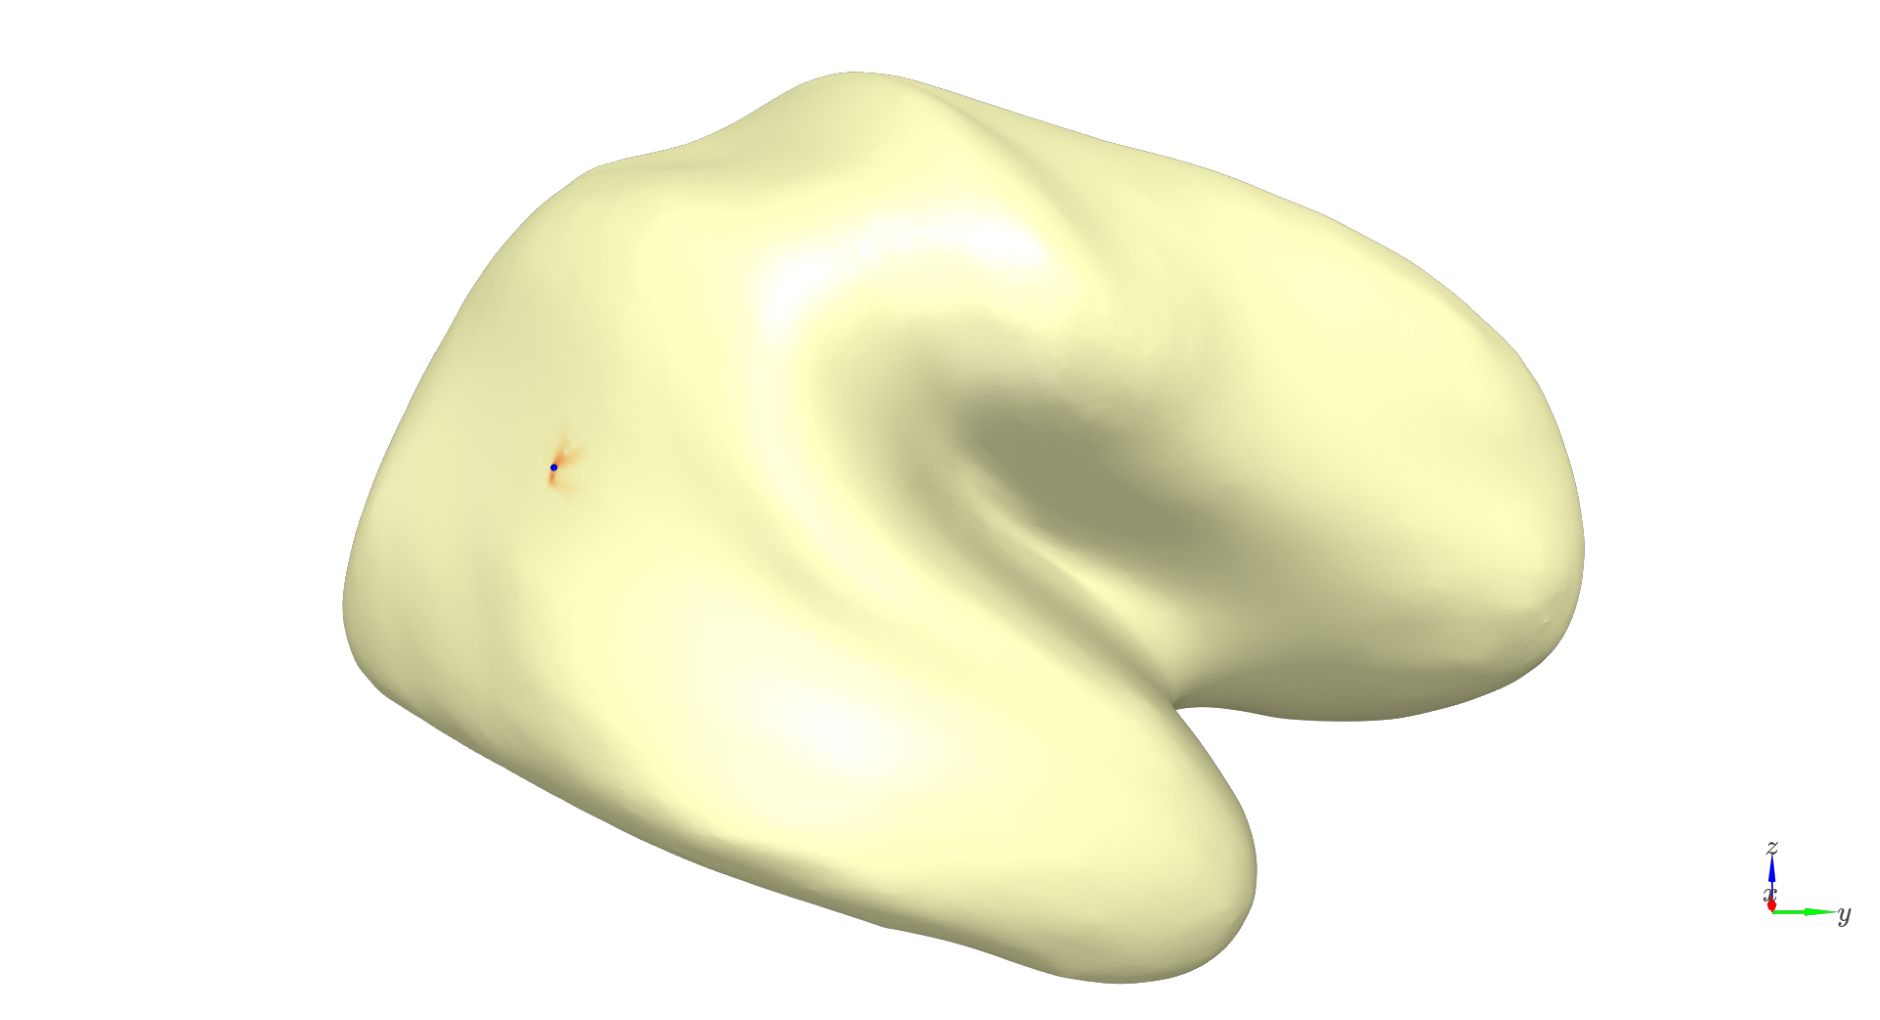

In [15]:
# Interpolate for display on the original inflated surface
interpolated_data = interpolate_data(orig_inflated, ds_inflated, m_layer_max)
          
# Plot colors and camera view
max_abs = np.max(np.abs(m_layer_max))
c_range = [-max_abs, max_abs]
cam_view=[289, 32, -19,
          3.5, 29, 26,
          0, 0, 1]

# Plot peak
colors,_ = color_map(
    interpolated_data, 
    "RdYlBu_r", 
    c_range[0], 
    c_range[1]    
)

plot = show_surface(
    orig_inflated, 
    vertex_colors=colors, 
    info=True, 
    camera_view=cam_view, 
    coords=prior_coord, 
    coord_size=2, 
    coord_color=[0,0,255]
)

## Sliding time window model comparison (pial - white matter)
Now we can run sliding time window model comparison between source models based on the pial and white matter surfaces using free energy. Specifically, we'll look at the difference in free energy between the two models (pial - white matter), in sliding and overlapping windows of 16ms. The free energy difference (pial - white matter) should be positive (more model evidence for the pial surface model) because we simulated activity on the pial surface.

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 10:50:54 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 10:50:54 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           10:51:14 - 22/07/2024
pial.ds.link_vector.fixed
undoing the G3BR balancing for the gradiometer definition
creating layout from cfg.grad
undoing the G3BR balancing for the gradiometer definition
creating layout for ctf275 sy

  ReML Iteration              : 13                            ...4.012794e+00
  ReML Iteration              : 14                            ...2.221325e+00
  ReML Iteration              : 15                            ...1.179176e+00
  ReML Iteration              : 16                            ...6.062672e-01
  ReML Iteration              : 17                            ...3.046085e-01
  ReML Iteration              : 18                            ...1.507122e-01
  ReML Iteration              : 19                            ...7.390487e-02
  ReML Iteration              : 20                            ...3.610527e-02
  ReML Iteration              : 21                            ...1.764337e-02
  ReML Iteration              : 22                            ...8.649230e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220726e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192818e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration 1                      :        ...5.824394e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188505e+02 [+4.25]
  ReML Iteration 3                      :        ...1.131868e+02 [+4.38]
  ReML Iteration 4                      :        ...1.041662e+02 [+4.50]
  ReML Iteration 5                      :        ...8.409599e+01 [+4.62]
  ReML Iteration 6                      :        ...2.210189e-05 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   11.06   -1.85

  ReML Iteration              : 1                            ...1.086549e+02
  ReML Iteration              : 2                            ...8.517409e+01
  ReML Iteration              : 3                            ...7.197798e+01
  ReML Iteration              : 4                            ...6.264431e+01
  ReML Iteration              : 5                            ...5.487056e+01
  ReML Iteration              : 6                            ...4.758645e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.981114e-01
  ReML Iteration              : 20                            ...1.494048e-01
  ReML Iteration              : 21                            ...1.726327e-01
  ReML Iteration              : 22                            ...4.099488e-01
  ReML Iteration              : 23                            ...3.088150e-01
  ReML Iteration              : 24                            ...9.350969e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219002e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194497e+02 [+4.25]
  ReML Iteration 3                      :        ...1.172132e+02 [+4.38]
  ReML Iteration 4                      :        ...1.118084e+02 [+4.50]
  ReML Iteration 5                      :        ...3.345551e-05 [+4.62]
Percent variance explained -18.43 (-9.78)
Number of samples 22
Fixed number of temporal modes
Using 4 temporal mode

  ReML Iteration              : 1                            ...1.086500e+02
  ReML Iteration              : 2                            ...8.516455e+01
  ReML Iteration              : 3                            ...7.196148e+01
  ReML Iteration              : 4                            ...6.261787e+01
  ReML Iteration              : 5                            ...5.483083e+01
  ReML Iteration              : 6                            ...4.753045e+01
  ReML Iteration              : 7                            ...4.020815e+01
  ReML Iteration              : 8                            ...3.274838e+01
  ReML Iteration              : 9                            ...2.537108e+01
  ReML Iteration              : 10                            ...1.852572e+01
  ReML Iteration              : 11                            ...1.269219e+01
  ReML Iteration              : 12                            ...8.167951e+00
  ReML Iteration              : 13                            ...4.969291

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219948e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193555e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169625e+02 [+4.38]
  ReML Iteration 4                      :        ...1.111668e+02 [+4.50]
  ReML Iteration 5                      :        ...2.225306e-03 [+4.62]
Percent variance explained -83.52 (-37.40)
Number of samples 28
Fixed number of temporal modes
Using 4 temporal modes, accounting for 41.40 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.830926e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187978e+02 [+4.25]
  ReML Iterati

  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.824266e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188515e+02 [+4.25]
  ReML Iteration 3                      :        ...1.131899e+02 [+4.38]
  ReML Iteration 4                      :        ...1.041736e+02 [+4.50]
  ReML Iteration 5                      :        ...8.411120e+01 [+4.62]
  ReML Iteration 6                      :        ...1.894496e-05 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   11.06   -1.85

  ReML Iteration              : 1                            ...1.086553e+02
  ReML Iteration              : 2                            ...8.517490e+01
  ReML Iteration              : 3                            ...7.197938e+01
  ReML Iteration              : 4                            ...6.264655e+01
  ReML Iteration              : 5                            ...5.487393e+01
  ReML Iteration              : 6    

  ReML Iteration              : 13                            ...3.773835e+00
  ReML Iteration              : 14                            ...2.062658e+00
  ReML Iteration              : 15                            ...1.079903e+00
  ReML Iteration              : 16                            ...5.469960e-01
  ReML Iteration              : 17                            ...2.704894e-01
  ReML Iteration              : 18                            ...1.316151e-01
  ReML Iteration              : 19                            ...6.343719e-02
  ReML Iteration              : 20                            ...3.045214e-02
  ReML Iteration              : 21                            ...1.462004e-02
  ReML Iteration              : 22                            ...7.041525e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.221193e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192391e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration 1                      :        ...5.986394e+02 [+4.12]
  ReML Iteration 2                      :        ...1.175688e+02 [+4.25]
  ReML Iteration 3                      :        ...1.094234e+02 [+4.38]
  ReML Iteration 4                      :        ...9.530460e+01 [+4.50]
  ReML Iteration 5                      :        ...6.708936e+01 [+4.62]
  ReML Iteration 6                      :        ...1.966235e-01 [+4.75]
  ReML Iteration 7                      :        ...3.962672e-07 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
   11.07   -1.65

  ReML Iteration              : 1                            ...1.083110e+02
  ReML Iteration              : 2                            ...8.416572e+01
  ReML Iteration              : 3                            ...7.024572e+01
  ReML Iteration              : 4                            ...5.990167e+01
  ReML Iteration              : 5                            ...5.082680e+01
  ReML Iteration              : 6    

  ReML Iteration 7                      :        ...1.635225e-05 [+4.88]
Percent variance explained -350.26 (-135.91)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.533849e+02 [+4.12]
  ReML Iteration 2                      :        ...1.135874e+02 [+4.25]
  ReML Iteration 3                      :        ...9.802500e+01 [+4.38]
  ReML Iteration 4                      :        ...7.152886e+01 [+4.50]
  ReML Iteration 5                      :        ...3.266858e+01 [+4.62]
  ReML Iteration 6                      :        ...3.554127e+00 [+4.75]
  ReML Iteration 7                      :        ...1.275486e-04

Percent variance explained -4423.38 (-1711.65)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.57 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.501775e+02 [+4.12]
  ReML Iteration 2                      :        ...9.910209e+01 [+4.25]
  ReML Iteration 3                      :        ...5.864843e+01 [+4.38]
  ReML Iteration 4                      :        ...1.954726e+01 [+4.50]
  ReML Iteration 5                      :        ...1.513763e+00 [+4.62]
  ReML Iteration 6                      :        ...6.676886e-03 [+4.75]
log evidence & hyperparameters:
    0.00 1254.78
   11.05    0.08

  ReML Iteration              : 1                            ...1.64

  ReML Iteration              : 7                            ...9.720638e-02
  ReML Iteration              : 8                            ...2.898632e-02
  ReML Iteration              : 9                            ...9.143092e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.075989e+03 [+4.12]
  ReML Iteration 2                      :        ...8.423129e+01 [+4.25]
  ReML Iteration 3                      :        ...3.433828e+01 [+4.38]
  ReML Iteration 4                      :        ...5.066042e+00 [+4.50]
  ReML Iteration 5                      :        ...6.997608e-02 [+4.62]
  ReML Iteration 6                      :        ...8.270594e-06 [+4.75]
Percent variance explained 92.16 (36.06)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 39.66 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  Re

Percent variance explained 97.63 (42.10)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 44.83 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...9.631879e+03 [+4.12]
  ReML Iteration 2                      :        ...1.736214e+03 [+4.25]
  ReML Iteration 3                      :        ...4.638124e+01 [+4.38]
  ReML Iteration 4                      :        ...3.033249e-02 [+4.50]
  ReML Iteration 5                      :        ...1.260963e-08 [+4.62]
log evidence & hyperparameters:
    0.00 20785.50
   10.90    3.01

  ReML Iteration              : 1                            ...6.878613e+03
  ReML Iteration              : 2                            ...8.982

Percent variance explained 98.93 (50.29)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.02 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.615174e+04 [+4.12]
  ReML Iteration 2                      :        ...5.847404e+03 [+4.25]
  ReML Iteration 3                      :        ...6.822723e+02 [+4.38]
  ReML Iteration 4                      :        ...9.383608e+00 [+4.50]
  ReML Iteration 5                      :        ...1.851116e-03 [+4.62]
log evidence & hyperparameters:
    0.00 34859.64
   10.70    3.77

  ReML Iteration              : 1                            ...1.306158e+04
  ReML Iteration              : 2                            ...3.447

  ReML Iteration              : 6                            ...2.560399e+01
  ReML Iteration              : 7                            ...6.909337e+00
  ReML Iteration              : 8                            ...2.012518e+00
  ReML Iteration              : 9                            ...6.273468e-01
  ReML Iteration              : 10                            ...2.073221e-01
  ReML Iteration              : 11                            ...7.202868e-02
  ReML Iteration              : 12                            ...2.612386e-02
  ReML Iteration              : 13                            ...9.834251e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.884760e+04 [+4.12]
  ReML Iteration 2                      :        ...7.689381e+03 [+4.25]
  ReML Iteration 3                      :        ...8.872808e+02 [+4.38]
  ReML Iteration 4                      :        ...7.819120e+00 [+4.50]
  ReML Iteration 5                  

  ReML Iteration 5                      :        ...3.200120e-02 [+4.62]
  ReML Iteration 6                      :        ...8.299740e-09 [+4.75]
Percent variance explained 99.57 (66.55)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 68.96 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.392105e+04 [+4.12]
  ReML Iteration 2                      :        ...1.509216e+04 [+4.25]
  ReML Iteration 3                      :        ...5.852264e+03 [+4.38]
  ReML Iteration 4                      :        ...1.133643e+03 [+4.50]
  ReML Iteration 5                      :        ...8.414071e+01 [+4.62]
  ReML Iteration 6                      :        ...1.031308e+00 [+4

  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.524476e+04 [+4.12]
  ReML Iteration 2                      :        ...1.721763e+04 [+4.25]
  ReML Iteration 3                      :        ...7.885743e+03 [+4.38]
  ReML Iteration 4                      :        ...2.182777e+03 [+4.50]
  ReML Iteration 5                      :        ...3.861314e+02 [+4.62]
  ReML Iteration 6                      :        ...2.646667e-08 [+4.75]
log evidence & hyperparameters:
    0.00 64039.38
    8.47    4.93

  ReML Iteration              : 1                            ...2.212088e+04
  ReML Iteration              : 2                            ...1.145146e+04
  ReML Iteration              : 3                            ...5.046306e+03
  ReML Iteration              : 4                            ...1.824230e+03
  ReML Iteration              : 5       

  ReML Iteration              : 1                            ...2.349279e+04
  ReML Iteration              : 2                            ...1.321473e+04
  ReML Iteration              : 3                            ...6.554679e+03
  ReML Iteration              : 4                            ...2.704688e+03
  ReML Iteration              : 5                            ...9.477623e+02
  ReML Iteration              : 6                            ...3.015859e+02
  ReML Iteration              : 7                            ...9.323460e+01
  ReML Iteration              : 8                            ...2.923488e+01
  ReML Iteration              : 9                            ...9.485525e+00
  ReML Iteration              : 10                            ...3.204849e+00
  ReML Iteration              : 11                            ...1.127442e+00
  ReML Iteration              : 12                            ...4.118713e-01
  ReML Iteration              : 13                            ...1.557098

  ReML Iteration              : 7                            ...1.515923e+02
  ReML Iteration              : 8                            ...4.886960e+01
  ReML Iteration              : 9                            ...1.610962e+01
  ReML Iteration              : 10                            ...5.492211e+00
  ReML Iteration              : 11                            ...1.942144e+00
  ReML Iteration              : 12                            ...7.116384e-01
  ReML Iteration              : 13                            ...2.695202e-01
  ReML Iteration              : 14                            ...1.051975e-01
  ReML Iteration              : 15                            ...4.219425e-02
  ReML Iteration              : 16                            ...1.734562e-02
  ReML Iteration              : 17                            ...7.291159e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.692142e+04 [+4.12]
  ReML Iteration 2  

  ReML Iteration              : 13                            ...3.989460e-01
  ReML Iteration              : 14                            ...1.558662e-01
  ReML Iteration              : 15                            ...6.255472e-02
  ReML Iteration              : 16                            ...2.572521e-02
  ReML Iteration              : 17                            ...1.081603e-02
  ReML Iteration              : 18                            ...4.639970e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.758341e+04 [+4.12]
  ReML Iteration 2                      :        ...2.061474e+04 [+4.25]
  ReML Iteration 3                      :        ...9.766154e+03 [+4.38]
  ReML Iteration 4                      :        ...1.607790e+03 [+4.50]
  ReML Iteration 5                      :        ...2.986265e+01 [+4.62]
  ReML Iteration 6                      :        ...8.320782e-03 [+4.75]
Percent variance explained 99.80 (83.66)
N

  ReML Iteration              : 13                            ...4.963624e-01
  ReML Iteration              : 14                            ...1.940490e-01
  ReML Iteration              : 15                            ...7.790914e-02
  ReML Iteration              : 16                            ...3.204738e-02
  ReML Iteration              : 17                            ...1.347622e-02
  ReML Iteration              : 18                            ...5.781728e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.792581e+04 [+4.12]
  ReML Iteration 2                      :        ...2.130022e+04 [+4.25]
  ReML Iteration 3                      :        ...1.061569e+04 [+4.38]
  ReML Iteration 4                      :        ...1.960440e+03 [+4.50]
  ReML Iteration 5                      :        ...4.596094e+01 [+4.62]
  ReML Iteration 6                      :        ...2.011479e-02 [+4.75]
  ReML Iteration 7                      : 

  ReML Iteration              : 13                            ...5.199841e-01
  ReML Iteration              : 14                            ...2.033130e-01
  ReML Iteration              : 15                            ...8.163576e-02
  ReML Iteration              : 16                            ...3.358215e-02
  ReML Iteration              : 17                            ...1.412209e-02
  ReML Iteration              : 18                            ...6.058965e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.799630e+04 [+4.12]
  ReML Iteration 2                      :        ...2.144321e+04 [+4.25]
  ReML Iteration 3                      :        ...1.079874e+04 [+4.38]
  ReML Iteration 4                      :        ...2.042074e+03 [+4.50]
  ReML Iteration 5                      :        ...5.024369e+01 [+4.62]
  ReML Iteration 6                      :        ...2.414907e-02 [+4.75]
  ReML Iteration 7                      : 

  ReML Iteration              : 12                            ...1.258199e+00
  ReML Iteration              : 13                            ...4.776972e-01
  ReML Iteration              : 14                            ...1.867303e-01
  ReML Iteration              : 15                            ...7.496539e-02
  ReML Iteration              : 16                            ...3.083512e-02
  ReML Iteration              : 17                            ...1.296609e-02
  ReML Iteration              : 18                            ...5.562766e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.786708e+04 [+4.12]
  ReML Iteration 2                      :        ...2.118157e+04 [+4.25]
  ReML Iteration 3                      :        ...1.046534e+04 [+4.38]
  ReML Iteration 4                      :        ...1.894904e+03 [+4.50]
  ReML Iteration 5                      :        ...4.267631e+01 [+4.62]
  ReML Iteration 6                   

  ReML Iteration              : 13                            ...3.706095e-01
  ReML Iteration              : 14                            ...1.447666e-01
  ReML Iteration              : 15                            ...5.809296e-02
  ReML Iteration              : 16                            ...2.388853e-02
  ReML Iteration              : 17                            ...1.004333e-02
  ReML Iteration              : 18                            ...4.308355e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.746374e+04 [+4.12]
  ReML Iteration 2                      :        ...2.037868e+04 [+4.25]
  ReML Iteration 3                      :        ...9.484174e+03 [+4.38]
  ReML Iteration 4                      :        ...1.500039e+03 [+4.50]
  ReML Iteration 5                      :        ...2.569985e+01 [+4.62]
  ReML Iteration 6                      :        ...6.123424e-03 [+4.75]
Percent variance explained 99.79 (83.06)
N

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.666516e+04 [+4.12]
  ReML Iteration 2                      :        ...1.884967e+04 [+4.25]
  ReML Iteration 3                      :        ...7.784475e+03 [+4.38]
  ReML Iteration 4                      :        ...9.432962e+02 [+4.50]
  ReML Iteration 5                      :        ...9.498162e+00 [+4.62]
  ReML Iteration 6                      :        ...8.075514e-04 [+4.75]
Percent variance explained 99.76 (80.83)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 79.96 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.701218e+04 [+4.12]
  ReML Iteration

Percent variance explained 99.71 (77.24)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.14 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.624447e+04 [+4.12]
  ReML Iteration 2                      :        ...1.893849e+04 [+4.25]
  ReML Iteration 3                      :        ...9.775465e+03 [+4.38]
  ReML Iteration 4                      :        ...3.462160e+03 [+4.50]
  ReML Iteration 5                      :        ...5.267526e-07 [+4.62]
log evidence & hyperparameters:
    0.00 68769.82
    8.76    5.10

  ReML Iteration              : 1                            ...2.313613e+04
  ReML Iteration              : 2                            ...1.274

  ReML Iteration 1                      :        ...2.465210e+04 [+4.12]
  ReML Iteration 2                      :        ...1.624470e+04 [+4.25]
  ReML Iteration 3                      :        ...6.913885e+03 [+4.38]
  ReML Iteration 4                      :        ...1.637831e+03 [+4.50]
  ReML Iteration 5                      :        ...1.990322e+02 [+4.62]
  ReML Iteration 6                      :        ...5.201318e-07 [+4.75]
log evidence & hyperparameters:
    0.00 61189.62
    9.07    4.83

  ReML Iteration              : 1                            ...2.152047e+04
  ReML Iteration              : 2                            ...1.073026e+04
  ReML Iteration              : 3                            ...4.490546e+03
  ReML Iteration              : 4                            ...1.537442e+03
  ReML Iteration              : 5                            ...4.597174e+02
  ReML Iteration              : 6                            ...1.312151e+02
  ReML Iteration              : 

  ReML Iteration              : 1                            ...1.918311e+04
  ReML Iteration              : 2                            ...8.200556e+03
  ReML Iteration              : 3                            ...2.809254e+03
  ReML Iteration              : 4                            ...7.934329e+02
  ReML Iteration              : 5                            ...2.063363e+02
  ReML Iteration              : 6                            ...5.418517e+01
  ReML Iteration              : 7                            ...1.500100e+01
  ReML Iteration              : 8                            ...4.427045e+00
  ReML Iteration              : 9                            ...1.389556e+00
  ReML Iteration              : 10                            ...4.609350e-01
  ReML Iteration              : 11                            ...1.604756e-01
  ReML Iteration              : 12                            ...5.827248e-02
  ReML Iteration              : 13                            ...2.195204

  ReML Iteration              : 13                            ...6.441128e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.755013e+04 [+4.12]
  ReML Iteration 2                      :        ...6.423141e+03 [+4.25]
  ReML Iteration 3                      :        ...5.843285e+02 [+4.38]
  ReML Iteration 4                      :        ...3.242720e+00 [+4.50]
  ReML Iteration 5                      :        ...8.527451e-05 [+4.62]
Percent variance explained 99.35 (57.34)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.43 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.764936e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.011527e+04
  ReML Iteration              : 2                            ...1.987641e+03
  ReML Iteration              : 3                            ...3.168395e+02
  ReML Iteration              : 4                            ...5.373175e+01
  ReML Iteration              : 5                            ...1.065468e+01
  ReML Iteration              : 6                            ...2.450624e+00
  ReML Iteration              : 7                            ...6.360051e-01
  ReML Iteration              : 8                            ...1.817084e-01
  ReML Iteration              : 9                            ...5.607931e-02
  ReML Iteration              : 10                            ...1.843337e-02
  ReML Iteration              : 11                            ...6.385044e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.125963e+04 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 7                            ...4.564477e-02
  ReML Iteration              : 8                            ...1.297083e-02
  ReML Iteration              : 9                            ...3.991825e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...4.386200e+03 [+4.12]
  ReML Iteration 2                      :        ...2.756852e+02 [+4.25]
  ReML Iteration 3                      :        ...8.676550e+00 [+4.38]
  ReML Iteration 4                      :        ...1.933444e-01 [+4.50]
  ReML Iteration 5                      :        ...6.468515e-05 [+4.62]
Percent variance explained 97.02 (40.94)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 40.71 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...5.968363e+02 [+4.12]
  ReML Iteration 2                      :        ...8.879232e+01 [+4.25]
  ReML Iteration 3                      :        ...4.985617e+01 [+4.38]
  ReML Iteration 4                      :        ...1.248106e+01 [+4.50]
  ReML Iteration 5                      :        ...5.081780e-01 [+4.62]
  ReML Iteration 6                      :        ...5.717831e-04 [+4.75]
Percent variance explained 89.40 (34.79)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.71 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.258836e+03 [+4.12]
  ReML Iteration

  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.847944e+02 [+4.12]
  ReML Iteration 2                      :        ...1.115250e+02 [+4.25]
  ReML Iteration 3                      :        ...9.227576e+01 [+4.38]
  ReML Iteration 4                      :        ...6.118264e+01 [+4.50]
  ReML Iteration 5                      :        ...2.222070e+01 [+4.62]
  ReML Iteration 6                      :        ...7.220083e+00 [+4.75]
  ReML Iteration 7                      :        ...5.238783e-04 [+4.88]
log evidence & hyperparameters:
    0.00   -0.00
   11.07   -0.94

  ReML Iteration              : 1                            ...1.118854e+02
  ReML Iteration              : 2                            ...7.928067e+01
  ReML Iteration              : 3                

Percent variance explained -457.42 (-176.77)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.172546e+02 [+4.12]
  ReML Iteration 2                      :        ...1.161564e+02 [+4.25]
  ReML Iteration 3                      :        ...1.053312e+02 [+4.38]
  ReML Iteration 4                      :        ...8.625022e+01 [+4.50]
  ReML Iteration 5                      :        ...5.214391e+01 [+4.62]
  ReML Iteration 6                      :        ...8.844948e-01 [+4.75]
  ReML Iteration 7                      :        ...7.956211e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.01
   11.06   -1.4

  ReML Iteration              : 19                            ...3.704507e-02
  ReML Iteration              : 20                            ...1.717477e-02
  ReML Iteration              : 21                            ...7.992860e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.223429e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190476e+02 [+4.25]
  ReML Iteration 3                      :        ...1.161458e+02 [+4.38]
  ReML Iteration 4                      :        ...1.090937e+02 [+4.50]
  ReML Iteration 5                      :        ...9.296064e+01 [+4.62]
  ReML Iteration 6                      :        ...4.874612e-02 [+4.75]
  ReML Iteration 7                      :        ...1.873937e-08 [+4.88]
Percent variance explained -60.47 (-23.28)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 39.92 percent average variance
Using 1 spatial source priors provided

  ReML Iteration              : 1                            ...1.086760e+02
  ReML Iteration              : 2                            ...8.521483e+01
  ReML Iteration              : 3                            ...7.204843e+01
  ReML Iteration              : 4                            ...6.275728e+01
  ReML Iteration              : 5                            ...5.504055e+01
  ReML Iteration              : 6                            ...4.782639e+01
  ReML Iteration              : 7                            ...4.059733e+01
  ReML Iteration              : 8                            ...3.322065e+01
  ReML Iteration              : 9                            ...2.589459e+01
  ReML Iteration              : 10                            ...1.905205e+01
  ReML Iteration              : 11                            ...1.317179e+01
  ReML Iteration              : 12                            ...8.566981e+00
  ReML Iteration              : 13                            ...5.277151

Percent variance explained -137.19 (-61.37)
Number of samples 25
Fixed number of temporal modes
Using 4 temporal modes, accounting for 46.54 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.796294e+02 [+4.12]
  ReML Iteration 2                      :        ...1.190780e+02 [+4.25]
  ReML Iteration 3                      :        ...1.138599e+02 [+4.38]
  ReML Iteration 4                      :        ...1.058064e+02 [+4.50]
  ReML Iteration 5                      :        ...8.751417e+01 [+4.62]
  ReML Iteration 6                      :        ...5.185362e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   11.06   -1.89

  ReML Iteration              : 1                            ...1.08751

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.218333e+02 [+4.12]
  ReML Iteration 2                      :        ...1.195199e+02 [+4.25]
  ReML Iteration 3                      :        ...1.174001e+02 [+4.38]
  ReML Iteration 4                      :        ...1.122884e+02 [+4.50]
  ReML Iteration 5                      :        ...2.041424e-03 [+4.62]
Percent variance explained -121.25 (-61.40)
Number of samples 22
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.13 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.816419e+02 [+4.12]
  ReML Iteration 2                      :        ...1.189149e+02 [+4.25]
  ReML Iterat

  ReML Iteration              : 7                            ...4.025304e+01
  ReML Iteration              : 8                            ...3.280271e+01
  ReML Iteration              : 9                            ...2.543110e+01
  ReML Iteration              : 10                            ...1.858580e+01
  ReML Iteration              : 11                            ...1.274667e+01
  ReML Iteration              : 12                            ...8.212995e+00
  ReML Iteration              : 13                            ...5.003778e+00
  ReML Iteration              : 14                            ...2.912628e+00
  ReML Iteration              : 15                            ...1.640376e+00
  ReML Iteration              : 16                            ...9.064036e-01
  ReML Iteration              : 17                            ...4.991161e-01
  ReML Iteration              : 18                            ...2.792749e-01
  ReML Iteration              : 19                            ...1.

  ReML Iteration              : 23                            ...6.777907e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220091e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193416e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169258e+02 [+4.38]
  ReML Iteration 4                      :        ...1.110729e+02 [+4.50]
  ReML Iteration 5                      :        ...3.019581e-03 [+4.62]
Percent variance explained -105.89 (-64.71)
Number of samples 17
Fixed number of temporal modes
Using 4 temporal modes, accounting for 64.68 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.839805e+02 [+4.12]
  ReML I

model evidences relative to maximum:

ans =

   1.0e+03 *

  Columns 1 through 7

   -1.8351   -1.8227   -1.8090   -1.7738   -1.7477   -1.6966   -1.6825

  Columns 8 through 14

   -1.6546   -1.6526   -1.6387   -1.6296   -1.6174   -1.6160   -1.6152

  Columns 15 through 21

   -1.6126   -1.6050   -1.5647   -1.5621   -1.5589   -1.5571   -1.5530

  Columns 22 through 28

   -1.5079   -1.4916   -1.4809   -1.4801   -1.4599   -1.4566   -1.4287

  Columns 29 through 35

   -1.4191   -1.4085   -1.3959   -1.3950   -1.3942   -1.3887   -1.3873

  Columns 36 through 42

   -1.3844   -1.3815   -1.3765   -1.3729   -1.3686   -1.3652   -1.3627

  Columns 43 through 49

   -1.3617   -1.3557   -1.3485   -1.2600   -1.2549   -1.2221   -1.2126

  Columns 50 through 56

   -1.1989   -1.1910   -1.1599   -1.1487   -1.1453   -1.1363   -1.1189

  Columns 57 through 63

   -1.1013   -1.0777   -1.0672   -1.0353   -1.0044   -0.9805   -0.9798

  Columns 64 through 70

   -0.8772   -0.8765   -0.7936   -0.7719   -0.

  ReML Iteration              : 13                            ...3.976323e+00
  ReML Iteration              : 14                            ...2.196906e+00
  ReML Iteration              : 15                            ...1.163743e+00
  ReML Iteration              : 16                            ...5.969395e-01
  ReML Iteration              : 17                            ...2.991601e-01
  ReML Iteration              : 18                            ...1.476108e-01
  ReML Iteration              : 19                            ...7.217267e-02
  ReML Iteration              : 20                            ...3.515077e-02
  ReML Iteration              : 21                            ...1.712218e-02
  ReML Iteration              : 22                            ...8.366256e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220795e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192755e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration              : 1                            ...1.086482e+02
  ReML Iteration              : 2                            ...8.516093e+01
  ReML Iteration              : 3                            ...7.195523e+01
  ReML Iteration              : 4                            ...6.260784e+01
  ReML Iteration              : 5                            ...5.481575e+01
  ReML Iteration              : 6                            ...4.750921e+01
  ReML Iteration              : 7                            ...4.018029e+01
  ReML Iteration              : 8                            ...3.271467e+01
  ReML Iteration              : 9                            ...2.533387e+01
  ReML Iteration              : 10                            ...1.848850e+01
  ReML Iteration              : 11                            ...1.265849e+01
  ReML Iteration              : 12                            ...8.140115e+00
  ReML Iteration              : 13                            ...4.948013

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.218986e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194513e+02 [+4.25]
  ReML Iteration 3                      :        ...1.172174e+02 [+4.38]
  ReML Iteration 4                      :        ...1.118191e+02 [+4.50]
  ReML Iteration 5                      :        ...4.450803e-05 [+4.62]
Percent variance explained -32.08 (-17.77)
Number of samples 22
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.06 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.826002e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188375e+02 [+4.25]
  ReML Iterati

  ReML Iteration              : 7                            ...4.023985e+01
  ReML Iteration              : 8                            ...3.278675e+01
  ReML Iteration              : 9                            ...2.541346e+01
  ReML Iteration              : 10                            ...1.856814e+01
  ReML Iteration              : 11                            ...1.273065e+01
  ReML Iteration              : 12                            ...8.199741e+00
  ReML Iteration              : 13                            ...4.993623e+00
  ReML Iteration              : 14                            ...2.905273e+00
  ReML Iteration              : 15                            ...1.635213e+00
  ReML Iteration              : 16                            ...9.027930e-01
  ReML Iteration              : 17                            ...4.965139e-01
  ReML Iteration              : 18                            ...2.772564e-01
  ReML Iteration              : 19                            ...1.

  ReML Iteration              : 25                            ...1.969096e-02
  ReML Iteration              : 26                            ...2.947290e-02
  ReML Iteration              : 27                            ...7.553345e-02
  ReML Iteration              : 28                            ...3.047213e-01
  ReML Iteration              : 29                            ...2.851819e-01
  ReML Iteration              : 30                            ...1.373209e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219483e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194010e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170837e+02 [+4.38]
  ReML Iteration 4                      :        ...1.114766e+02 [+4.50]
  ReML Iteration 5                      :        ...4.648544e-04 [+4.62]
Percent variance explained -52.63 (-24.46)
Number of samples 26
Fixed number of temporal modes
Using 4 temporal mod

  ReML Iteration 1                      :        ...5.831305e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187948e+02 [+4.25]
  ReML Iteration 3                      :        ...1.130222e+02 [+4.38]
  ReML Iteration 4                      :        ...1.037677e+02 [+4.50]
  ReML Iteration 5                      :        ...8.327857e+01 [+4.62]
  ReML Iteration 6                      :        ...5.539930e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   11.06   -1.26

  ReML Iteration              : 1                            ...1.086329e+02
  ReML Iteration              : 2                            ...8.513043e+01
  ReML Iteration              : 3                            ...7.190253e+01
  ReML Iteration              : 4                            ...6.252345e+01
  ReML Iteration              : 5                            ...5.468901e+01
  ReML Iteration              : 6                            ...4.733082e+01
  ReML Iteration              : 7

  ReML Iteration              : 13                            ...3.947713e+00
  ReML Iteration              : 14                            ...2.177802e+00
  ReML Iteration              : 15                            ...1.151708e+00
  ReML Iteration              : 16                            ...5.896949e-01
  ReML Iteration              : 17                            ...2.949494e-01
  ReML Iteration              : 18                            ...1.452278e-01
  ReML Iteration              : 19                            ...7.085055e-02
  ReML Iteration              : 20                            ...3.442755e-02
  ReML Iteration              : 21                            ...1.673032e-02
  ReML Iteration              : 22                            ...8.155182e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220849e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192705e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration 6                      :        ...6.836535e-02 [+4.75]
  ReML Iteration 7                      :        ...4.828619e-08 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
   11.07   -1.15

  ReML Iteration              : 1                            ...1.084111e+02
  ReML Iteration              : 2                            ...8.458179e+01
  ReML Iteration              : 3                            ...7.095787e+01
  ReML Iteration              : 4                            ...6.102099e+01
  ReML Iteration              : 5                            ...5.245793e+01
  ReML Iteration              : 6                            ...4.424343e+01
  ReML Iteration              : 7                            ...3.599804e+01
  ReML Iteration              : 8                            ...2.781772e+01
  ReML Iteration              : 9                            ...2.014777e+01
  ReML Iteration              : 10                            ...1.355519e+01
  ReML Iteration

  ReML Iteration 5                      :        ...7.861379e+01 [+4.62]
  ReML Iteration 6                      :        ...6.639792e-01 [+4.75]
  ReML Iteration 7                      :        ...3.400418e-06 [+4.88]
Percent variance explained -204.07 (-79.08)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.80 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.261409e+02 [+4.12]
  ReML Iteration 2                      :        ...1.155041e+02 [+4.25]
  ReML Iteration 3                      :        ...1.034595e+02 [+4.38]
  ReML Iteration 4                      :        ...8.230555e+01 [+4.50]
  ReML Iteration 5                      :        ...4.636013e+01 

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.379639e+02 [+4.12]
  ReML Iteration 2                      :        ...1.137798e+02 [+4.25]
  ReML Iteration 3                      :        ...1.027606e+02 [+4.38]
  ReML Iteration 4                      :        ...7.871043e+01 [+4.50]
  ReML Iteration 5                      :        ...3.998230e+01 [+4.62]
  ReML Iteration 6                      :        ...1.094043e+01 [+4.75]
  ReML Iteration 7                      :        ...9.021006e-04 [+4.88]
Percent variance explained -1741.25 (-672.70)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.70 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iter

Percent variance explained 81.33 (31.46)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.91 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.661471e+03 [+4.12]
  ReML Iteration 2                      :        ...9.423059e+01 [+4.25]
  ReML Iteration 3                      :        ...2.300981e+01 [+4.38]
  ReML Iteration 4                      :        ...2.135311e+00 [+4.50]
  ReML Iteration 5                      :        ...1.288593e-02 [+4.62]
  ReML Iteration 6                      :        ...5.181937e-07 [+4.75]
log evidence & hyperparameters:
    0.00 3514.91
   11.03    1.61

  ReML Iteration              : 1                            ...4.674356e+

Percent variance explained 95.48 (38.72)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 41.70 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.225984e+03 [+4.12]
  ReML Iteration 2                      :        ...6.468943e+02 [+4.25]
  ReML Iteration 3                      :        ...5.978383e+00 [+4.38]
  ReML Iteration 4                      :        ...1.335542e-03 [+4.50]
log evidence & hyperparameters:
    0.00 13946.40
   10.96    3.08

  ReML Iteration              : 1                            ...3.859844e+03
  ReML Iteration              : 2                            ...2.995661e+02
  ReML Iteration              : 3                            ...2

  ReML Iteration 1                      :        ...1.280952e+04 [+4.12]
  ReML Iteration 2                      :        ...3.375610e+03 [+4.25]
  ReML Iteration 3                      :        ...1.999133e+02 [+4.38]
  ReML Iteration 4                      :        ...6.609995e-01 [+4.50]
  ReML Iteration 5                      :        ...7.146960e-06 [+4.62]
log evidence & hyperparameters:
    0.00 27343.17
   10.84    3.99

  ReML Iteration              : 1                            ...9.844671e+03
  ReML Iteration              : 2                            ...1.876985e+03
  ReML Iteration              : 3                            ...2.925289e+02
  ReML Iteration              : 4                            ...4.908853e+01
  ReML Iteration              : 5                            ...9.692140e+00
  ReML Iteration              : 6                            ...2.225179e+00
  ReML Iteration              : 7                            ...5.770188e-01
  ReML Iteration            

Percent variance explained 98.62 (54.55)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 57.56 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.879296e+04 [+4.12]
  ReML Iteration 2                      :        ...8.406825e+03 [+4.25]
  ReML Iteration 3                      :        ...1.549505e+03 [+4.38]
  ReML Iteration 4                      :        ...5.762152e+01 [+4.50]
  ReML Iteration 5                      :        ...9.306553e-02 [+4.62]
  ReML Iteration 6                      :        ...2.544700e-07 [+4.75]
log evidence & hyperparameters:
    0.00 41576.91
   10.55    4.66

  ReML Iteration              : 1                            ...1.565437e

  ReML Iteration              : 7                            ...1.330574e+01
  ReML Iteration              : 8                            ...3.917442e+00
  ReML Iteration              : 9                            ...1.228060e+00
  ReML Iteration              : 10                            ...4.070862e-01
  ReML Iteration              : 11                            ...1.416738e-01
  ReML Iteration              : 12                            ...5.143376e-02
  ReML Iteration              : 13                            ...1.937329e-02
  ReML Iteration              : 14                            ...7.536771e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.083298e+04 [+4.12]
  ReML Iteration 2                      :        ...9.923884e+03 [+4.25]
  ReML Iteration 3                      :        ...1.619125e+03 [+4.38]
  ReML Iteration 4                      :        ...2.826062e+01 [+4.50]
  ReML Iteration 5                 

  ReML Iteration              : 13                            ...3.952051e-02
  ReML Iteration              : 14                            ...1.538258e-02
  ReML Iteration              : 15                            ...6.159379e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.275755e+04 [+4.12]
  ReML Iteration 2                      :        ...1.245916e+04 [+4.25]
  ReML Iteration 3                      :        ...2.796971e+03 [+4.38]
  ReML Iteration 4                      :        ...9.301074e+01 [+4.50]
  ReML Iteration 5                      :        ...7.644317e-02 [+4.62]
  ReML Iteration 6                      :        ...4.797608e-08 [+4.75]
Percent variance explained 99.05 (69.96)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 72.52 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
 

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.468851e+04 [+4.12]
  ReML Iteration 2                      :        ...1.539836e+04 [+4.25]
  ReML Iteration 3                      :        ...4.698210e+03 [+4.38]
  ReML Iteration 4                      :        ...2.959175e+02 [+4.50]
  ReML Iteration 5                      :        ...8.303247e-01 [+4.62]
  ReML Iteration 6                      :        ...5.854445e-06 [+4.75]
Percent variance explained 99.14 (75.24)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 77.41 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.595092e+04 [+4.12]
  ReML Iteration

  ReML Iteration 5                      :        ...4.125177e+00 [+4.62]
  ReML Iteration 6                      :        ...1.490102e-04 [+4.75]
Percent variance explained 99.18 (79.25)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 80.92 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.699500e+04 [+4.12]
  ReML Iteration 2                      :        ...2.029742e+04 [+4.25]
  ReML Iteration 3                      :        ...1.142238e+04 [+4.38]
  ReML Iteration 4                      :        ...4.799130e+03 [+4.50]
  ReML Iteration 5                      :        ...1.851529e-06 [+4.62]
log evidence & hyperparameters:
    0.00 72262.71
    8.27    5.89



Percent variance explained 99.21 (81.92)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.25 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.766816e+04 [+4.12]
  ReML Iteration 2                      :        ...2.156604e+04 [+4.25]
  ReML Iteration 3                      :        ...1.308301e+04 [+4.38]
  ReML Iteration 4                      :        ...6.337355e+03 [+4.50]
  ReML Iteration 5                      :        ...3.631814e-06 [+4.62]
log evidence & hyperparameters:
    0.00 75353.97
    7.62    6.03

  ReML Iteration              : 1                            ...2.458706e+04
  ReML Iteration              : 2                            ...1.474

  ReML Iteration 1                      :        ...2.806424e+04 [+4.12]
  ReML Iteration 2                      :        ...2.233478e+04 [+4.25]
  ReML Iteration 3                      :        ...1.414702e+04 [+4.38]
  ReML Iteration 4                      :        ...7.414040e+03 [+4.50]
  ReML Iteration 5                      :        ...4.911722e-06 [+4.62]
log evidence & hyperparameters:
    0.00 77155.09
    7.14    6.13

  ReML Iteration              : 1                            ...2.499173e+04
  ReML Iteration              : 2                            ...1.533223e+04
  ReML Iteration              : 3                            ...8.659032e+03
  ReML Iteration              : 4                            ...4.185438e+03
  ReML Iteration              : 5                            ...1.711205e+03
  ReML Iteration              : 6                            ...6.148122e+02
  ReML Iteration              : 7                            ...2.061128e+02
  ReML Iteration            

  ReML Iteration 1                      :        ...2.819832e+04 [+4.12]
  ReML Iteration 2                      :        ...2.259878e+04 [+4.25]
  ReML Iteration 3                      :        ...1.452244e+04 [+4.38]
  ReML Iteration 4                      :        ...7.809664e+03 [+4.50]
  ReML Iteration 5                      :        ...5.381035e-06 [+4.62]
log evidence & hyperparameters:
    0.00 77761.87
    6.96    6.17

  ReML Iteration              : 1                            ...2.512881e+04
  ReML Iteration              : 2                            ...1.553618e+04
  ReML Iteration              : 3                            ...8.879239e+03
  ReML Iteration              : 4                            ...4.357675e+03
  ReML Iteration              : 5                            ...1.810091e+03
  ReML Iteration              : 6                            ...6.591245e+02
  ReML Iteration              : 7                            ...2.230840e+02
  ReML Iteration            

  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.814210e+04 [+4.12]
  ReML Iteration 2                      :        ...2.248785e+04 [+4.25]
  ReML Iteration 3                      :        ...1.436407e+04 [+4.38]
  ReML Iteration 4                      :        ...7.641805e+03 [+4.50]
  ReML Iteration 5                      :        ...5.182101e-06 [+4.62]
log evidence & hyperparameters:
    0.00 77507.63
    7.04    6.15

  ReML Iteration              : 1                            ...2.507132e+04
  ReML Iteration              : 2                            ...1.545044e+04
  ReML Iteration              : 3                            ...8.786283e+03
  ReML Iteration              : 4                            ...4.284565e+03
  ReML Iteration              : 5                            ...1.767863e+03
  ReML Iteration              : 6   

  ReML Iteration 1                      :        ...2.785409e+04 [+4.12]
  ReML Iteration 2                      :        ...2.192485e+04 [+4.25]
  ReML Iteration 3                      :        ...1.357422e+04 [+4.38]
  ReML Iteration 4                      :        ...6.826023e+03 [+4.50]
  ReML Iteration 5                      :        ...4.212383e-06 [+4.62]
log evidence & hyperparameters:
    0.00 76201.09
    7.40    6.07

  ReML Iteration              : 1                            ...2.477697e+04
  ReML Iteration              : 2                            ...1.501624e+04
  ReML Iteration              : 3                            ...8.324027e+03
  ReML Iteration              : 4                            ...3.929749e+03
  ReML Iteration              : 5                            ...1.568244e+03
  ReML Iteration              : 6                            ...5.522141e+02
  ReML Iteration              : 7                            ...1.825377e+02
  ReML Iteration            

  ReML Iteration 3                      :        ...1.208941e+04 [+4.38]
  ReML Iteration 4                      :        ...5.395157e+03 [+4.50]
  ReML Iteration 5                      :        ...2.526617e-06 [+4.62]
log evidence & hyperparameters:
    0.00 73549.86
    8.02    5.95

  ReML Iteration              : 1                            ...2.418506e+04
  ReML Iteration              : 2                            ...1.416730e+04
  ReML Iteration              : 3                            ...7.460776e+03
  ReML Iteration              : 4                            ...3.305868e+03
  ReML Iteration              : 5                            ...1.238809e+03
  ReML Iteration              : 6                            ...4.147532e+02
  ReML Iteration              : 7                            ...1.324964e+02
  ReML Iteration              : 8                            ...4.235820e+01
  ReML Iteration              : 9                            ...1.389594e+01
  ReML Iteration    

  ReML Iteration              : 1                            ...2.327632e+04
  ReML Iteration              : 2                            ...1.292563e+04
  ReML Iteration              : 3                            ...6.292519e+03
  ReML Iteration              : 4                            ...2.540910e+03
  ReML Iteration              : 5                            ...8.730485e+02
  ReML Iteration              : 6                            ...2.738599e+02
  ReML Iteration              : 7                            ...8.390767e+01
  ReML Iteration              : 8                            ...2.617434e+01
  ReML Iteration              : 9                            ...8.467786e+00
  ReML Iteration              : 10                            ...2.856296e+00
  ReML Iteration              : 11                            ...1.003883e+00
  ReML Iteration              : 12                            ...3.665335e-01
  ReML Iteration              : 13                            ...1.385250

  ReML Iteration              : 6                            ...1.869143e+02
  ReML Iteration              : 7                            ...5.548596e+01
  ReML Iteration              : 8                            ...1.700118e+01
  ReML Iteration              : 9                            ...5.445644e+00
  ReML Iteration              : 10                            ...1.826685e+00
  ReML Iteration              : 11                            ...6.399818e-01
  ReML Iteration              : 12                            ...2.332387e-01
  ReML Iteration              : 13                            ...8.805275e-02
  ReML Iteration              : 14                            ...3.430194e-02
  ReML Iteration              : 15                            ...1.374208e-02
  ReML Iteration              : 16                            ...5.645068e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.468308e+04 [+4.12]
  ReML Iteration 2   

  ReML Iteration              : 7                            ...2.592901e+01
  ReML Iteration              : 8                            ...7.750763e+00
  ReML Iteration              : 9                            ...2.449484e+00
  ReML Iteration              : 10                            ...8.155706e-01
  ReML Iteration              : 11                            ...2.845394e-01
  ReML Iteration              : 12                            ...1.034480e-01
  ReML Iteration              : 13                            ...3.899803e-02
  ReML Iteration              : 14                            ...1.517904e-02
  ReML Iteration              : 15                            ...6.077836e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.272336e+04 [+4.12]
  ReML Iteration 2                      :        ...1.241079e+04 [+4.25]
  ReML Iteration 3                      :        ...2.770705e+03 [+4.38]
  ReML Iteration 4            

  ReML Iteration              : 13                            ...1.377345e-02
  ReML Iteration              : 14                            ...5.357256e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.985055e+04 [+4.12]
  ReML Iteration 2                      :        ...8.771790e+03 [+4.25]
  ReML Iteration 3                      :        ...1.208646e+03 [+4.38]
  ReML Iteration 4                      :        ...1.508875e+01 [+4.50]
  ReML Iteration 5                      :        ...1.895496e-03 [+4.62]
Percent variance explained 98.91 (61.82)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 60.11 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML

  ReML Iteration              : 1                            ...1.299756e+04
  ReML Iteration              : 2                            ...3.410749e+03
  ReML Iteration              : 3                            ...6.920129e+02
  ReML Iteration              : 4                            ...1.332762e+02
  ReML Iteration              : 5                            ...2.794259e+01
  ReML Iteration              : 6                            ...6.585209e+00
  ReML Iteration              : 7                            ...1.728289e+00
  ReML Iteration              : 8                            ...4.964814e-01
  ReML Iteration              : 9                            ...1.536558e-01
  ReML Iteration              : 10                            ...5.058300e-02
  ReML Iteration              : 11                            ...1.753585e-02
  ReML Iteration              : 12                            ...6.352157e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

log evidence & hyperparameters:
    0.00 20236.17
   10.92    3.57

  ReML Iteration              : 1                            ...6.629249e+03
  ReML Iteration              : 2                            ...8.344213e+02
  ReML Iteration              : 3                            ...9.973198e+01
  ReML Iteration              : 4                            ...1.501298e+01
  ReML Iteration              : 5                            ...2.843130e+00
  ReML Iteration              : 6                            ...6.416024e-01
  ReML Iteration              : 7                            ...1.650935e-01
  ReML Iteration              : 8                            ...4.697278e-02
  ReML Iteration              : 9                            ...1.446615e-02
  ReML Iteration              : 10                            ...4.749640e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.429762e+03 [+4.12]
  ReML Iteration 2                  

  ReML Iteration              : 7                            ...3.672794e-02
  ReML Iteration              : 8                            ...1.065372e-02
  ReML Iteration              : 9                            ...3.312261e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.930443e+03 [+4.12]
  ReML Iteration 2                      :        ...9.787812e+01 [+4.25]
  ReML Iteration 3                      :        ...2.125930e+01 [+4.38]
  ReML Iteration 4                      :        ...1.646368e+00 [+4.50]
  ReML Iteration 5                      :        ...6.297680e-03 [+4.62]
Percent variance explained 94.27 (38.00)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 39.60 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  Re

  ReML Iteration              : 1                            ...1.618068e+02
  ReML Iteration              : 2                            ...6.830807e+01
  ReML Iteration              : 3                            ...4.544899e+01
  ReML Iteration              : 4                            ...2.773782e+01
  ReML Iteration              : 5                            ...1.480620e+01
  ReML Iteration              : 6                            ...6.849331e+00
  ReML Iteration              : 7                            ...2.808532e+00
  ReML Iteration              : 8                            ...1.063805e+00
  ReML Iteration              : 9                            ...3.880583e-01
  ReML Iteration              : 10                            ...1.405884e-01
  ReML Iteration              : 11                            ...5.152181e-02
  ReML Iteration              : 12                            ...1.927563e-02
  ReML Iteration              : 13                            ...7.388970

  ReML Iteration              : 7                            ...1.901113e+01
  ReML Iteration              : 8                            ...1.131455e+01
  ReML Iteration              : 9                            ...6.069993e+00
  ReML Iteration              : 10                            ...2.969218e+00
  ReML Iteration              : 11                            ...1.352074e+00
  ReML Iteration              : 12                            ...5.869993e-01
  ReML Iteration              : 13                            ...2.482699e-01
  ReML Iteration              : 14                            ...1.039936e-01
  ReML Iteration              : 15                            ...4.362076e-02
  ReML Iteration              : 16                            ...1.844618e-02
  ReML Iteration              : 17                            ...7.893255e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.284855e+02 [+4.12]
  ReML Iteration 2  

  ReML Iteration 7                      :        ...2.832846e-07 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
   11.06   -1.10

  ReML Iteration              : 1                            ...1.083260e+02
  ReML Iteration              : 2                            ...8.424734e+01
  ReML Iteration              : 3                            ...7.038513e+01
  ReML Iteration              : 4                            ...6.011989e+01
  ReML Iteration              : 5                            ...5.114273e+01
  ReML Iteration              : 6                            ...4.247004e+01
  ReML Iteration              : 7                            ...3.381228e+01
  ReML Iteration              : 8                            ...2.538741e+01
  ReML Iteration              : 9                            ...1.773879e+01
  ReML Iteration              : 10                            ...1.144115e+01
  ReML Iteration              : 11                            ...6.802047e+00
  ReML Iter

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.221729e+02 [+4.12]
  ReML Iteration 2                      :        ...1.191914e+02 [+4.25]
  ReML Iteration 3                      :        ...1.165268e+02 [+4.38]
  ReML Iteration 4                      :        ...1.100574e+02 [+4.50]
  ReML Iteration 5                      :        ...9.513295e+01 [+4.62]
  ReML Iteration 6                      :        ...1.950020e-02 [+4.75]
  ReML Iteration 7                      :        ...3.043407e-09 [+4.88]
Percent variance explained -38.17 (-15.23)
Number of samples 29
Fixed number of temporal modes
Using 4 temporal modes, accounting for 41.53 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iterati

  ReML Iteration              : 7                            ...4.050502e+01
  ReML Iteration              : 8                            ...3.310838e+01
  ReML Iteration              : 9                            ...2.576977e+01
  ReML Iteration              : 10                            ...1.892611e+01
  ReML Iteration              : 11                            ...1.305653e+01
  ReML Iteration              : 12                            ...8.470580e+00
  ReML Iteration              : 13                            ...5.202291e+00
  ReML Iteration              : 14                            ...3.057557e+00
  ReML Iteration              : 15                            ...1.743265e+00
  ReML Iteration              : 16                            ...9.796833e-01
  ReML Iteration              : 17                            ...5.536295e-01
  ReML Iteration              : 18                            ...3.241382e-01
  ReML Iteration              : 19                            ...2.

  ReML Iteration              : 1                            ...1.087525e+02
  ReML Iteration              : 2                            ...8.535451e+01
  ReML Iteration              : 3                            ...7.229019e+01
  ReML Iteration              : 4                            ...6.314585e+01
  ReML Iteration              : 5                            ...5.562728e+01
  ReML Iteration              : 6                            ...4.865903e+01
  ReML Iteration              : 7                            ...4.170127e+01
  ReML Iteration              : 8                            ...3.457543e+01
  ReML Iteration              : 9                            ...2.741852e+01
  ReML Iteration              : 10                            ...2.061254e+01
  ReML Iteration              : 11                            ...1.462567e+01
  ReML Iteration              : 12                            ...9.809661e+00
  ReML Iteration              : 13                            ...6.269264

  ReML Iteration 1                      :        ...5.821400e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188746e+02 [+4.25]
  ReML Iteration 3                      :        ...1.132582e+02 [+4.38]
  ReML Iteration 4                      :        ...1.043394e+02 [+4.50]
  ReML Iteration 5                      :        ...8.445303e+01 [+4.62]
  ReML Iteration 6                      :        ...1.200780e-05 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   11.05   -1.28

  ReML Iteration              : 1                            ...1.086646e+02
  ReML Iteration              : 2                            ...8.519303e+01
  ReML Iteration              : 3                            ...7.201072e+01
  ReML Iteration              : 4                            ...6.269680e+01
  ReML Iteration              : 5                            ...5.494951e+01
  ReML Iteration              : 6                            ...4.769780e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.439776e-01
  ReML Iteration              : 20                            ...8.519218e-02
  ReML Iteration              : 21                            ...5.509112e-02
  ReML Iteration              : 22                            ...4.113764e-02
  ReML Iteration              : 23                            ...3.878711e-02
  ReML Iteration              : 24                            ...5.423329e-02
  ReML Iteration              : 25                            ...1.470369e-01
  ReML Iteration              : 26                            ...3.919248e-01
  ReML Iteration              : 27                            ...3.128041e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219364e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194130e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171155e+02 [+4.38]
  ReML Iteration 4         

  ReML Iteration              : 1                            ...1.086320e+02
  ReML Iteration              : 2                            ...8.512859e+01
  ReML Iteration              : 3                            ...7.189935e+01
  ReML Iteration              : 4                            ...6.251834e+01
  ReML Iteration              : 5                            ...5.468135e+01
  ReML Iteration              : 6                            ...4.732005e+01
  ReML Iteration              : 7                            ...3.993248e+01
  ReML Iteration              : 8                            ...3.241554e+01
  ReML Iteration              : 9                            ...2.500454e+01
  ReML Iteration              : 10                            ...1.816019e+01
  ReML Iteration              : 11                            ...1.236238e+01
  ReML Iteration              : 12                            ...7.896753e+00
  ReML Iteration              : 13                            ...4.763092

Text(0, 0.5, '$\\Delta$F')

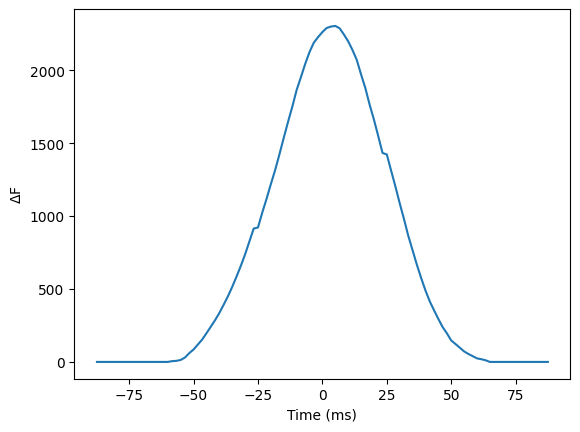

In [10]:
# Number of temporal models for sliding time window inversion
sliding_n_temp_modes = 4
# Size of sliding window (in ms)
win_size = 50
# Whether or not windows overlap
win_overlap = True

# Run sliding time window model comparison between the first layer (pial) and the last layer (white matter)
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    pial_sim_fname,     
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': sliding_n_temp_modes,
        'win_size': win_size, 
        'win_overlap': win_overlap,
    }
)

# Plot difference in free energy over time (pial minus white) - this should be positive
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

## White matter surface simulation with pial - white matter sliding time window model comparison
Let's simulate the same pattern of activity, in the same location, but on the white matter surface. This time, sliding time window model comparison should yield greater model evidence for the white matter surface, and therefore the difference in free energy (pial - white matter) should be negative.

Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING DIPOLE SOURCES
computing surface normals
Setting white noise to give sensor level SNR of -10B

 Finish
Smoothing ../test_data/sub-104/surf/multilayer.11.ds.link_vector.fixed.gii

smoothmeshname =

    '../test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat'


Found smoothfile ../test_data/sub-104/surf/FWHM5.00_multilayer.11.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 274 spatial modes

Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/sliding_window/sim_24585_white_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  



------------------------------------------------------------------------
22-Jul-2024 11:23:11 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 11:23:11 - Running 'Source inversion, iterative'
Using 1 iterations of 1 patches
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_24585_white_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_1.mat'

Checking leadfieldspatchiter 1/1
Checking leadfields
ans =

    0.3535    0.6389
    0.7484    0.7424

 - done

Found smoothfile /home/bonaiuto/laMEG/test_data/sub-104/surf/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 274 spatial modesNumber of samples 16
Fixed number of temporal modes
Using 4 temporal modes, accounting for 67.61 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1             

  ReML Iteration              : 1                            ...1.085751e+02
  ReML Iteration              : 2                            ...8.500891e+01
  ReML Iteration              : 3                            ...7.169274e+01
  ReML Iteration              : 4                            ...6.218804e+01
  ReML Iteration              : 5                            ...5.418679e+01
  ReML Iteration              : 6                            ...4.662715e+01
  ReML Iteration              : 7                            ...3.903062e+01
  ReML Iteration              : 8                            ...3.133638e+01
  ReML Iteration              : 9                            ...2.382991e+01
  ReML Iteration              : 10                            ...1.700554e+01
  ReML Iteration              : 11                            ...1.133830e+01
  ReML Iteration              : 12                            ...7.071709e+00
  ReML Iteration              : 13                            ...4.151154

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219764e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193733e+02 [+4.25]
  ReML Iteration 3                      :        ...1.170100e+02 [+4.38]
  ReML Iteration 4                      :        ...1.112882e+02 [+4.50]
  ReML Iteration 5                      :        ...1.378364e-03 [+4.62]
Percent variance explained -35.80 (-20.89)
Number of samples 20
Fixed number of temporal modes
Using 4 temporal modes, accounting for 55.56 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.829832e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188066e+02 [+4.25]
  ReML Iterati

  ReML Iteration              : 7                            ...3.957192e+01
  ReML Iteration              : 8                            ...3.198230e+01
  ReML Iteration              : 9                            ...2.453044e+01
  ReML Iteration              : 10                            ...1.769107e+01
  ReML Iteration              : 11                            ...1.194304e+01
  ReML Iteration              : 12                            ...7.555776e+00
  ReML Iteration              : 13                            ...4.507364e+00
  ReML Iteration              : 14                            ...2.559631e+00
  ReML Iteration              : 15                            ...1.398915e+00
  ReML Iteration              : 16                            ...7.438747e-01
  ReML Iteration              : 17                            ...3.887866e-01
  ReML Iteration              : 18                            ...2.015689e-01
  ReML Iteration              : 19                            ...1.

Percent variance explained -17.24 (-8.05)
Number of samples 25
Fixed number of temporal modes
Using 4 temporal modes, accounting for 46.69 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.827458e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188258e+02 [+4.25]
  ReML Iteration 3                      :        ...1.131138e+02 [+4.38]
  ReML Iteration 4                      :        ...1.039893e+02 [+4.50]
  ReML Iteration 5                      :        ...8.373250e+01 [+4.62]
  ReML Iteration 6                      :        ...1.703818e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   10.87   -2.03

  ReML Iteration              : 1                            ...1.086451e

  ReML Iteration              : 6                            ...4.681928e+01
  ReML Iteration              : 7                            ...3.927977e+01
  ReML Iteration              : 8                            ...3.163302e+01
  ReML Iteration              : 9                            ...2.415069e+01
  ReML Iteration              : 10                            ...1.731832e+01
  ReML Iteration              : 11                            ...1.161302e+01
  ReML Iteration              : 12                            ...7.290477e+00
  ReML Iteration              : 13                            ...4.311139e+00
  ReML Iteration              : 14                            ...2.423806e+00
  ReML Iteration              : 15                            ...1.309352e+00
  ReML Iteration              : 16                            ...6.866763e-01
  ReML Iteration              : 17                            ...3.528900e-01
  ReML Iteration              : 18                            ...1.7

  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.861504e+02 [+4.12]
  ReML Iteration 2                      :        ...1.185524e+02 [+4.25]
  ReML Iteration 3                      :        ...1.123073e+02 [+4.38]
  ReML Iteration 4                      :        ...1.020484e+02 [+4.50]
  ReML Iteration 5                      :        ...7.980956e+01 [+4.62]
  ReML Iteration 6                      :        ...1.117747e-02 [+4.75]
  ReML Iteration 7                      :        ...1.324301e-09 [+4.88]
log evidence & hyperparameters:
    0.00   -0.03
   10.85   -2.00

  ReML Iteration              : 1                            ...1.085446e+02
  ReML Iteration              : 2                            ...8.494033e+01
  ReML Iteration              : 3                            ...7.157449e+01
  ReML Iteration              : 4            

  ReML Iteration              : 19                            ...6.367517e-02
  ReML Iteration              : 20                            ...3.057777e-02
  ReML Iteration              : 21                            ...1.468566e-02
  ReML Iteration              : 22                            ...7.075603e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.221181e+02 [+4.12]
  ReML Iteration 2                      :        ...1.192402e+02 [+4.25]
  ReML Iteration 3                      :        ...1.166563e+02 [+4.38]
  ReML Iteration 4                      :        ...1.103865e+02 [+4.50]
  ReML Iteration 5                      :        ...9.588229e+01 [+4.62]
  ReML Iteration 6                      :        ...1.257122e-02 [+4.75]
  ReML Iteration 7                      :        ...1.277050e-09 [+4.88]
Percent variance explained -19.85 (-7.62)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, account

  ReML Iteration              : 1                            ...1.082700e+02
  ReML Iteration              : 2                            ...8.365132e+01
  ReML Iteration              : 3                            ...6.937029e+01
  ReML Iteration              : 4                            ...5.854133e+01
  ReML Iteration              : 5                            ...4.887993e+01
  ReML Iteration              : 6                            ...3.949946e+01
  ReML Iteration              : 7                            ...3.028543e+01
  ReML Iteration              : 8                            ...2.165438e+01
  ReML Iteration              : 9                            ...1.425728e+01
  ReML Iteration              : 10                            ...8.595565e+00
  ReML Iteration              : 11                            ...4.757730e+00
  ReML Iteration              : 12                            ...2.442302e+00
  ReML Iteration              : 13                            ...1.180469

  ReML Iteration 1                      :        ...6.913874e+02 [+4.12]
  ReML Iteration 2                      :        ...1.111110e+02 [+4.25]
  ReML Iteration 3                      :        ...9.113299e+01 [+4.38]
  ReML Iteration 4                      :        ...5.925058e+01 [+4.50]
  ReML Iteration 5                      :        ...2.054122e+01 [+4.62]
  ReML Iteration 6                      :        ...8.140645e+00 [+4.75]
  ReML Iteration 7                      :        ...6.653617e-04 [+4.88]
log evidence & hyperparameters:
    0.00   -0.00
   10.89   -1.07

  ReML Iteration              : 1                            ...1.124939e+02
  ReML Iteration              : 2                            ...7.893669e+01
  ReML Iteration              : 3                            ...6.159447e+01
  ReML Iteration              : 4                            ...4.720198e+01
  ReML Iteration              : 5                            ...3.413968e+01
  ReML Iteration              : 6    

  ReML Iteration              : 1                            ...2.373344e+02
  ReML Iteration              : 2                            ...6.179981e+01
  ReML Iteration              : 3                            ...3.609101e+01
  ReML Iteration              : 4                            ...1.882268e+01
  ReML Iteration              : 5                            ...8.376381e+00
  ReML Iteration              : 6                            ...3.243946e+00
  ReML Iteration              : 7                            ...1.149000e+00
  ReML Iteration              : 8                            ...3.919348e-01
  ReML Iteration              : 9                            ...1.335649e-01
  ReML Iteration              : 10                            ...4.640268e-02
  ReML Iteration              : 11                            ...1.658162e-02
  ReML Iteration              : 12                            ...6.110455e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

  ReML Iteration 1                      :        ...4.193302e+03 [+4.12]
  ReML Iteration 2                      :        ...2.824699e+02 [+4.25]
  ReML Iteration 3                      :        ...3.228168e+00 [+4.38]
  ReML Iteration 4                      :        ...1.661513e-02 [+4.50]
  ReML Iteration 5                      :        ...9.340406e-07 [+4.62]
log evidence & hyperparameters:
    0.00 9690.39
   10.80    1.90

  ReML Iteration              : 1                            ...2.196912e+03
  ReML Iteration              : 2                            ...1.216153e+02
  ReML Iteration              : 3                            ...1.353689e+01
  ReML Iteration              : 4                            ...2.290662e+00
  ReML Iteration              : 5                            ...4.692991e-01
  ReML Iteration              : 6                            ...1.101150e-01
  ReML Iteration              : 7                            ...2.886229e-02
  ReML Iteration             

  ReML Iteration              : 1                            ...7.536757e+03
  ReML Iteration              : 2                            ...1.079924e+03
  ReML Iteration              : 3                            ...1.390053e+02
  ReML Iteration              : 4                            ...2.150941e+01
  ReML Iteration              : 5                            ...4.114850e+00
  ReML Iteration              : 6                            ...9.324120e-01
  ReML Iteration              : 7                            ...2.403640e-01
  ReML Iteration              : 8                            ...6.844955e-02
  ReML Iteration              : 9                            ...2.108992e-02
  ReML Iteration              : 10                            ...6.926108e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.428109e+03 [+4.12]
  ReML Iteration 2                      :        ...1.096985e+03 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.342029e+04
  ReML Iteration              : 2                            ...3.659160e+03
  ReML Iteration              : 3                            ...7.692656e+02
  ReML Iteration              : 4                            ...1.513145e+02
  ReML Iteration              : 5                            ...3.204178e+01
  ReML Iteration              : 6                            ...7.585284e+00
  ReML Iteration              : 7                            ...1.994944e+00
  ReML Iteration              : 8                            ...5.736747e-01
  ReML Iteration              : 9                            ...1.776408e-01
  ReML Iteration              : 10                            ...5.849548e-02
  ReML Iteration              : 11                            ...2.028213e-02
  ReML Iteration              : 12                            ...7.347633e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 97.86 (59.88)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 63.42 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.116959e+04 [+4.12]
  ReML Iteration 2                      :        ...1.120987e+04 [+4.25]
  ReML Iteration 3                      :        ...2.978350e+03 [+4.38]
  ReML Iteration 4                      :        ...2.496096e+02 [+4.50]
  ReML Iteration 5                      :        ...2.483856e+00 [+4.62]
  ReML Iteration 6                      :        ...2.983983e-04 [+4.75]
log evidence & hyperparameters:
    0.00 48539.70
   10.12    4.20

  ReML Iteration              : 1                            ...1.801714e

  ReML Iteration              : 1                            ...1.974806e+04
  ReML Iteration              : 2                            ...8.772624e+03
  ReML Iteration              : 3                            ...3.153846e+03
  ReML Iteration              : 4                            ...9.306693e+02
  ReML Iteration              : 5                            ...2.493438e+02
  ReML Iteration              : 6                            ...6.659285e+01
  ReML Iteration              : 7                            ...1.860029e+01
  ReML Iteration              : 8                            ...5.514695e+00
  ReML Iteration              : 9                            ...1.735202e+00
  ReML Iteration              : 10                            ...5.763626e-01
  ReML Iteration              : 11                            ...2.008128e-01
  ReML Iteration              : 12                            ...7.295144e-02
  ReML Iteration              : 13                            ...2.748881

  ReML Iteration              : 7                            ...3.809412e+01
  ReML Iteration              : 8                            ...1.151703e+01
  ReML Iteration              : 9                            ...3.662099e+00
  ReML Iteration              : 10                            ...1.223436e+00
  ReML Iteration              : 11                            ...4.276490e-01
  ReML Iteration              : 12                            ...1.556479e-01
  ReML Iteration              : 13                            ...5.871444e-02
  ReML Iteration              : 14                            ...2.286207e-02
  ReML Iteration              : 15                            ...9.156378e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.374203e+04 [+4.12]
  ReML Iteration 2                      :        ...1.390627e+04 [+4.25]
  ReML Iteration 3                      :        ...3.655997e+03 [+4.38]
  ReML Iteration 4            

  ReML Iteration              : 13                            ...1.062883e-01
  ReML Iteration              : 14                            ...4.141634e-02
  ReML Iteration              : 15                            ...1.659484e-02
  ReML Iteration              : 16                            ...6.817606e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.509665e+04 [+4.12]
  ReML Iteration 2                      :        ...1.607322e+04 [+4.25]
  ReML Iteration 3                      :        ...5.224984e+03 [+4.38]
  ReML Iteration 4                      :        ...3.765845e+02 [+4.50]
  ReML Iteration 5                      :        ...1.371640e+00 [+4.62]
  ReML Iteration 6                      :        ...1.611120e-05 [+4.75]
Percent variance explained 98.20 (77.53)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 80.01 percent average variance
Using 1 spatial source priors provi

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.599580e+04 [+4.12]
  ReML Iteration 2                      :        ...1.762873e+04 [+4.25]
  ReML Iteration 3                      :        ...6.578545e+03 [+4.38]
  ReML Iteration 4                      :        ...6.383598e+02 [+4.50]
  ReML Iteration 5                      :        ...4.150330e+00 [+4.62]
  ReML Iteration 6                      :        ...1.508543e-04 [+4.75]
Percent variance explained 98.22 (80.26)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 82.37 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.690123e+04 [+4.12]
  ReML Iteration

Percent variance explained 98.23 (81.91)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.75 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.733347e+04 [+4.12]
  ReML Iteration 2                      :        ...2.092937e+04 [+4.25]
  ReML Iteration 3                      :        ...1.223475e+04 [+4.38]
  ReML Iteration 4                      :        ...5.528991e+03 [+4.50]
  ReML Iteration 5                      :        ...2.681542e-06 [+4.62]
log evidence & hyperparameters:
    0.00 73821.85
    7.85    5.27

  ReML Iteration              : 1                            ...2.424545e+04
  ReML Iteration              : 2                            ...1.425

  ReML Iteration 1                      :        ...2.745464e+04 [+4.12]
  ReML Iteration 2                      :        ...2.115850e+04 [+4.25]
  ReML Iteration 3                      :        ...1.253659e+04 [+4.38]
  ReML Iteration 4                      :        ...5.811351e+03 [+4.50]
  ReML Iteration 5                      :        ...3.011129e-06 [+4.62]
log evidence & hyperparameters:
    0.00 74377.61
    7.74    5.31

  ReML Iteration              : 1                            ...2.436909e+04
  ReML Iteration              : 2                            ...1.442780e+04
  ReML Iteration              : 3                            ...7.720020e+03
  ReML Iteration              : 4                            ...3.487957e+03
  ReML Iteration              : 5                            ...1.332100e+03
  ReML Iteration              : 6                            ...4.526980e+02
  ReML Iteration              : 7                            ...1.460634e+02
  ReML Iteration            

  ReML Iteration              : 1                            ...2.426501e+04
  ReML Iteration              : 2                            ...1.428010e+04
  ReML Iteration              : 3                            ...7.572424e+03
  ReML Iteration              : 4                            ...3.383735e+03
  ReML Iteration              : 5                            ...1.278414e+03
  ReML Iteration              : 6                            ...4.307652e+02
  ReML Iteration              : 7                            ...1.381978e+02
  ReML Iteration              : 8                            ...4.429389e+01
  ReML Iteration              : 9                            ...1.455235e+01
  ReML Iteration              : 10                            ...4.951781e+00
  ReML Iteration              : 11                            ...1.749103e+00
  ReML Iteration              : 12                            ...6.404902e-01
  ReML Iteration              : 13                            ...2.424810

  ReML Iteration              : 7                            ...1.181908e+02
  ReML Iteration              : 8                            ...3.753371e+01
  ReML Iteration              : 9                            ...1.226625e+01
  ReML Iteration              : 10                            ...4.161307e+00
  ReML Iteration              : 11                            ...1.467341e+00
  ReML Iteration              : 12                            ...5.367708e-01
  ReML Iteration              : 13                            ...2.030923e-01
  ReML Iteration              : 14                            ...7.922265e-02
  ReML Iteration              : 15                            ...3.176426e-02
  ReML Iteration              : 16                            ...1.305500e-02
  ReML Iteration              : 17                            ...5.486826e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.640485e+04 [+4.12]
  ReML Iteration 2  

  ReML Iteration              : 13                            ...1.485674e-01
  ReML Iteration              : 14                            ...5.792068e-02
  ReML Iteration              : 15                            ...2.321519e-02
  ReML Iteration              : 16                            ...9.539300e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.579535e+04 [+4.12]
  ReML Iteration 2                      :        ...1.727366e+04 [+4.25]
  ReML Iteration 3                      :        ...6.251948e+03 [+4.38]
  ReML Iteration 4                      :        ...5.677054e+02 [+4.50]
  ReML Iteration 5                      :        ...3.241460e+00 [+4.62]
  ReML Iteration 6                      :        ...9.150632e-05 [+4.75]
Percent variance explained 98.22 (79.56)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 80.09 percent average variance
Using 1 spatial source priors provi

Percent variance explained 98.18 (76.41)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 76.44 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.524515e+04 [+4.12]
  ReML Iteration 2                      :        ...1.721826e+04 [+4.25]
  ReML Iteration 3                      :        ...7.886404e+03 [+4.38]
  ReML Iteration 4                      :        ...2.183175e+03 [+4.50]
  ReML Iteration 5                      :        ...3.862920e+02 [+4.62]
  ReML Iteration 6                      :        ...2.635179e-08 [+4.75]
log evidence & hyperparameters:
    0.00 64041.21
    8.35    4.82

  ReML Iteration              : 1                            ...2.212126e

  ReML Iteration 1                      :        ...2.416991e+04 [+4.12]
  ReML Iteration 2                      :        ...1.547865e+04 [+4.25]
  ReML Iteration 3                      :        ...6.197470e+03 [+4.38]
  ReML Iteration 4                      :        ...1.287048e+03 [+4.50]
  ReML Iteration 5                      :        ...1.133328e+02 [+4.62]
  ReML Iteration 6                      :        ...2.149584e+00 [+4.75]
  ReML Iteration 7                      :        ...1.319636e-03 [+4.88]
log evidence & hyperparameters:
    0.00 59336.12
    9.22    4.64

  ReML Iteration              : 1                            ...2.103282e+04
  ReML Iteration              : 2                            ...1.016645e+04
  ReML Iteration              : 3                            ...4.080122e+03
  ReML Iteration              : 4                            ...1.338635e+03
  ReML Iteration              : 5                            ...3.873077e+02
  ReML Iteration              : 6   

  ReML Iteration              : 1                            ...1.891782e+04
  ReML Iteration              : 2                            ...7.940300e+03
  ReML Iteration              : 3                            ...2.659203e+03
  ReML Iteration              : 4                            ...7.361683e+02
  ReML Iteration              : 5                            ...1.889286e+02
  ReML Iteration              : 6                            ...4.925125e+01
  ReML Iteration              : 7                            ...1.358321e+01
  ReML Iteration              : 8                            ...4.000727e+00
  ReML Iteration              : 9                            ...1.254433e+00
  ReML Iteration              : 10                            ...4.158761e-01
  ReML Iteration              : 11                            ...1.447421e-01
  ReML Iteration              : 12                            ...5.254964e-02
  ReML Iteration              : 13                            ...1.979403

  ReML Iteration              : 13                            ...6.827461e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.773081e+04 [+4.12]
  ReML Iteration 2                      :        ...6.590690e+03 [+4.25]
  ReML Iteration 3                      :        ...6.201303e+02 [+4.38]
  ReML Iteration 4                      :        ...3.673737e+00 [+4.50]
  ReML Iteration 5                      :        ...1.096349e-04 [+4.62]
Percent variance explained 97.96 (57.64)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 56.62 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...1.788778e+04 [+4.12]
  ReML Iter

  ReML Iteration              : 1                            ...1.053433e+04
  ReML Iteration              : 2                            ...2.166488e+03
  ReML Iteration              : 3                            ...3.576346e+02
  ReML Iteration              : 4                            ...6.167661e+01
  ReML Iteration              : 5                            ...1.231539e+01
  ReML Iteration              : 6                            ...2.840979e+00
  ReML Iteration              : 7                            ...7.383058e-01
  ReML Iteration              : 8                            ...2.110738e-01
  ReML Iteration              : 9                            ...6.516392e-02
  ReML Iteration              : 10                            ...2.142334e-02
  ReML Iteration              : 11                            ...7.421462e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.171925e+04 [+4.12]
  ReML Iteration 2        

  ReML Iteration              : 1                            ...4.581332e+03
  ReML Iteration              : 2                            ...4.092936e+02
  ReML Iteration              : 3                            ...4.190442e+01
  ReML Iteration              : 4                            ...6.015074e+00
  ReML Iteration              : 5                            ...1.121023e+00
  ReML Iteration              : 6                            ...2.513877e-01
  ReML Iteration              : 7                            ...6.450406e-02
  ReML Iteration              : 8                            ...1.832757e-02
  ReML Iteration              : 9                            ...5.640197e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...5.171756e+03 [+4.12]
  ReML Iteration 2                      :        ...3.795069e+02 [+4.25]
  ReML Iteration 3                      :        ...7.463348e+00 [+4.38]
  ReML Iteration 4                  

  ReML Iteration              : 7                            ...1.396215e-01
  ReML Iteration              : 8                            ...4.211858e-02
  ReML Iteration              : 9                            ...1.336829e-02
  ReML Iteration              : 10                            ...4.459056e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.847108e+02 [+4.12]
  ReML Iteration 2                      :        ...8.479817e+01 [+4.25]
  ReML Iteration 3                      :        ...3.927067e+01 [+4.38]
  ReML Iteration 4                      :        ...6.986282e+00 [+4.50]
  ReML Iteration 5                      :        ...1.408519e-01 [+4.62]
  ReML Iteration 6                      :        ...3.772466e-05 [+4.75]
Percent variance explained 89.98 (35.34)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.60 percent average variance
Using 1 spatial source priors provided

Percent variance explained 69.28 (26.67)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.37 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...7.344078e+02 [+4.12]
  ReML Iteration 2                      :        ...1.085611e+02 [+4.25]
  ReML Iteration 3                      :        ...8.416552e+01 [+4.38]
  ReML Iteration 4                      :        ...4.832606e+01 [+4.50]
  ReML Iteration 5                      :        ...1.252420e+01 [+4.62]
  ReML Iteration 6                      :        ...6.175748e-01 [+4.75]
  ReML Iteration 7                      :        ...1.262720e-03 [+4.88]
log evidence & hyperparameters:
    0.00  467.50
   10.85   -0.93

 

Percent variance explained -325.03 (-124.94)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.46 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...6.031011e+02 [+4.12]
  ReML Iteration 2                      :        ...1.172245e+02 [+4.25]
  ReML Iteration 3                      :        ...1.084207e+02 [+4.38]
  ReML Iteration 4                      :        ...9.303064e+01 [+4.50]
  ReML Iteration 5                      :        ...6.311106e+01 [+4.62]
  ReML Iteration 6                      :        ...3.172298e-01 [+4.75]
  ReML Iteration 7                      :        ...1.028662e-06 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
   10.86   -1.8

  ReML Iteration              : 13                            ...3.309487e+00
  ReML Iteration              : 14                            ...1.763292e+00
  ReML Iteration              : 15                            ...8.989718e-01
  ReML Iteration              : 16                            ...4.432273e-01
  ReML Iteration              : 17                            ...2.134111e-01
  ReML Iteration              : 18                            ...1.012170e-01
  ReML Iteration              : 19                            ...4.762663e-02
  ReML Iteration              : 20                            ...2.235911e-02
  ReML Iteration              : 21                            ...1.051653e-02
  ReML Iteration              : 22                            ...4.969919e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.222261e+02 [+4.12]
  ReML Iteration 2                      :        ...1.191451e+02 [+4.25]
  ReML Iteration 3    

  ReML Iteration 1                      :        ...5.872321e+02 [+4.12]
  ReML Iteration 2                      :        ...1.184660e+02 [+4.25]
  ReML Iteration 3                      :        ...1.120529e+02 [+4.38]
  ReML Iteration 4                      :        ...1.014412e+02 [+4.50]
  ReML Iteration 5                      :        ...7.860666e+01 [+4.62]
  ReML Iteration 6                      :        ...1.825548e-02 [+4.75]
  ReML Iteration 7                      :        ...3.500183e-09 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
   10.86   -1.98

  ReML Iteration              : 1                            ...1.085160e+02
  ReML Iteration              : 2                            ...8.487250e+01
  ReML Iteration              : 3                            ...7.145763e+01
  ReML Iteration              : 4                            ...6.181333e+01
  ReML Iteration              : 5                            ...5.362855e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...9.435482e-02
  ReML Iteration              : 20                            ...4.806745e-02
  ReML Iteration              : 21                            ...2.463181e-02
  ReML Iteration              : 22                            ...1.273281e-02
  ReML Iteration              : 23                            ...6.649740e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220110e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193398e+02 [+4.25]
  ReML Iteration 3                      :        ...1.169209e+02 [+4.38]
  ReML Iteration 4                      :        ...1.110604e+02 [+4.50]
  ReML Iteration 5                      :        ...3.134415e-03 [+4.62]
Percent variance explained -313.55 (-135.82)
Number of samples 26
Fixed number of temporal modes
Using 4 temporal modes, accounting for 44.99 percent average variance
Using 1 spatial source pri

  ReML Iteration              : 7                            ...3.879205e+01
  ReML Iteration              : 8                            ...3.105342e+01
  ReML Iteration              : 9                            ...2.352541e+01
  ReML Iteration              : 10                            ...1.671042e+01
  ReML Iteration              : 11                            ...1.108095e+01
  ReML Iteration              : 12                            ...6.868484e+00
  ReML Iteration              : 13                            ...4.004024e+00
  ReML Iteration              : 14                            ...2.215446e+00
  ReML Iteration              : 15                            ...1.175456e+00
  ReML Iteration              : 16                            ...6.040145e-01
  ReML Iteration              : 17                            ...3.032899e-01
  ReML Iteration              : 18                            ...1.499597e-01
  ReML Iteration              : 19                            ...7.

  ReML Iteration 1                      :        ...5.842239e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187068e+02 [+4.25]
  ReML Iteration 3                      :        ...1.127625e+02 [+4.38]
  ReML Iteration 4                      :        ...1.031410e+02 [+4.50]
  ReML Iteration 5                      :        ...8.200326e+01 [+4.62]
  ReML Iteration 6                      :        ...2.843078e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   10.86   -2.02

  ReML Iteration              : 1                            ...1.085995e+02
  ReML Iteration              : 2                            ...8.506147e+01
  ReML Iteration              : 3                            ...7.178344e+01
  ReML Iteration              : 4                            ...6.233292e+01
  ReML Iteration              : 5                            ...5.440344e+01
  ReML Iteration              : 6                            ...4.693008e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...8.408290e-02
  ReML Iteration              : 20                            ...4.188738e-02
  ReML Iteration              : 21                            ...2.090771e-02
  ReML Iteration              : 22                            ...1.048489e-02
  ReML Iteration              : 23                            ...5.291923e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220382e+02 [+4.12]
  ReML Iteration 2                      :        ...1.193140e+02 [+4.25]
  ReML Iteration 3                      :        ...1.168522e+02 [+4.38]
  ReML Iteration 4                      :        ...1.108853e+02 [+4.50]
  ReML Iteration 5                      :        ...4.973340e-03 [+4.62]
Percent variance explained -72.82 (-42.32)
Number of samples 18
Fixed number of temporal modes
Using 4 temporal modes, accounting for 60.83 percent average variance
Using 1 spatial source prior

  ReML Iteration              : 1                            ...1.086708e+02
  ReML Iteration              : 2                            ...8.520481e+01
  ReML Iteration              : 3                            ...7.203109e+01
  ReML Iteration              : 4                            ...6.272947e+01
  ReML Iteration              : 5                            ...5.499867e+01
  ReML Iteration              : 6                            ...4.776722e+01
  ReML Iteration              : 7                            ...4.051939e+01
  ReML Iteration              : 8                            ...3.312585e+01
  ReML Iteration              : 9                            ...2.578918e+01
  ReML Iteration              : 10                            ...1.894567e+01
  ReML Iteration              : 11                            ...1.307442e+01
  ReML Iteration              : 12                            ...8.485519e+00
  ReML Iteration              : 13                            ...5.213872


Preparing modes file  block 1 of 1 for 274 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/sliding_window/sim_24585_white_pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
22-Jul-2024 11:31:21 - Running job #1
------------------------------------------------------------------------
22-Jul-2024 11:31:21 - Running 'Source inversion, iterative'
Using 1 iterations of 1 patches
Loadin

  ReML Iteration 1                      :        ...5.845413e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186813e+02 [+4.25]
  ReML Iteration 3                      :        ...1.126874e+02 [+4.38]
  ReML Iteration 4                      :        ...1.029600e+02 [+4.50]
  ReML Iteration 5                      :        ...8.163732e+01 [+4.62]
  ReML Iteration 6                      :        ...3.838777e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   10.87   -1.45

  ReML Iteration              : 1                            ...1.085901e+02
  ReML Iteration              : 2                            ...8.504149e+01
  ReML Iteration              : 3                            ...7.174895e+01
  ReML Iteration              : 4                            ...6.227780e+01
  ReML Iteration              : 5                            ...5.432096e+01
  ReML Iteration              : 6                            ...4.681465e+01
  ReML Iteration              : 7

  ReML Iteration              : 19                            ...1.450618e-01
  ReML Iteration              : 20                            ...8.618389e-02
  ReML Iteration              : 21                            ...5.616533e-02
  ReML Iteration              : 22                            ...4.258382e-02
  ReML Iteration              : 23                            ...4.141616e-02
  ReML Iteration              : 24                            ...6.178963e-02
  ReML Iteration              : 25                            ...1.847300e-01
  ReML Iteration              : 26                            ...3.837171e-01
  ReML Iteration              : 27                            ...2.890729e-05
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219353e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194140e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171182e+02 [+4.38]
  ReML Iteration 4         

  ReML Iteration 1                      :        ...5.829346e+02 [+4.12]
  ReML Iteration 2                      :        ...1.188106e+02 [+4.25]
  ReML Iteration 3                      :        ...1.130688e+02 [+4.38]
  ReML Iteration 4                      :        ...1.038804e+02 [+4.50]
  ReML Iteration 5                      :        ...8.350937e+01 [+4.62]
  ReML Iteration 6                      :        ...3.311975e-04 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   10.87   -1.47

  ReML Iteration              : 1                            ...1.086391e+02
  ReML Iteration              : 2                            ...8.514280e+01
  ReML Iteration              : 3                            ...7.192391e+01
  ReML Iteration              : 4                            ...6.255767e+01
  ReML Iteration              : 5                            ...5.474039e+01
  ReML Iteration              : 6                            ...4.740310e+01
  ReML Iteration              : 7

  ReML Iteration              : 7                            ...4.027853e+01
  ReML Iteration              : 8                            ...3.283358e+01
  ReML Iteration              : 9                            ...2.546523e+01
  ReML Iteration              : 10                            ...1.862000e+01
  ReML Iteration              : 11                            ...1.277770e+01
  ReML Iteration              : 12                            ...8.238688e+00
  ReML Iteration              : 13                            ...5.023480e+00
  ReML Iteration              : 14                            ...2.926916e+00
  ReML Iteration              : 15                            ...1.650420e+00
  ReML Iteration              : 16                            ...9.134458e-01
  ReML Iteration              : 17                            ...5.042132e-01
  ReML Iteration              : 18                            ...2.832592e-01
  ReML Iteration              : 19                            ...1.

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.219417e+02 [+4.12]
  ReML Iteration 2                      :        ...1.194076e+02 [+4.25]
  ReML Iteration 3                      :        ...1.171012e+02 [+4.38]
  ReML Iteration 4                      :        ...1.115214e+02 [+4.50]
  ReML Iteration 5                      :        ...3.188796e-04 [+4.62]
Percent variance explained -28.26 (-12.66)
Number of samples 28
Fixed number of temporal modes
Using 4 temporal modes, accounting for 41.44 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.843405e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186975e+02 [+4.25]
  ReML Iterati

  ReML Iteration              : 13                            ...4.172066e+00
  ReML Iteration              : 14                            ...2.328815e+00
  ReML Iteration              : 15                            ...1.247789e+00
  ReML Iteration              : 16                            ...6.482576e-01
  ReML Iteration              : 17                            ...3.295196e-01
  ReML Iteration              : 18                            ...1.651640e-01
  ReML Iteration              : 19                            ...8.215899e-02
  ReML Iteration              : 20                            ...4.077022e-02
  ReML Iteration              : 21                            ...2.026172e-02
  ReML Iteration              : 22                            ...1.011240e-02
  ReML Iteration              : 23                            ...5.077614e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220441e+02 [+4.12]
  ReML Iteration 

  ReML Iteration 1                      :        ...5.864301e+02 [+4.12]
  ReML Iteration 2                      :        ...1.185301e+02 [+4.25]
  ReML Iteration 3                      :        ...1.122414e+02 [+4.38]
  ReML Iteration 4                      :        ...1.018910e+02 [+4.50]
  ReML Iteration 5                      :        ...7.949651e+01 [+4.62]
  ReML Iteration 6                      :        ...1.284289e-02 [+4.75]
  ReML Iteration 7                      :        ...1.743405e-09 [+4.88]
log evidence & hyperparameters:
    0.00   -0.03
   10.86   -1.44

  ReML Iteration              : 1                            ...1.085371e+02
  ReML Iteration              : 2                            ...8.492278e+01
  ReML Iteration              : 3                            ...7.154423e+01
  ReML Iteration              : 4                            ...6.195121e+01
  ReML Iteration              : 5                            ...5.383362e+01
  ReML Iteration              : 6    

  ReML Iteration              : 19                            ...1.704360e-02
  ReML Iteration              : 20                            ...7.742442e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.228795e+02 [+4.12]
  ReML Iteration 2                      :        ...1.186513e+02 [+4.25]
  ReML Iteration 3                      :        ...1.151005e+02 [+4.38]
  ReML Iteration 4                      :        ...1.064783e+02 [+4.50]
  ReML Iteration 5                      :        ...8.723001e+01 [+4.62]
  ReML Iteration 6                      :        ...1.981962e-01 [+4.75]
  ReML Iteration 7                      :        ...3.054828e-07 [+4.88]
Percent variance explained -113.10 (-43.74)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 38.86 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  R

  ReML Iteration              : 7                            ...1.808885e+01
  ReML Iteration              : 8                            ...1.057891e+01
  ReML Iteration              : 9                            ...5.574025e+00
  ReML Iteration              : 10                            ...2.681591e+00
  ReML Iteration              : 11                            ...1.204255e+00
  ReML Iteration              : 12                            ...5.173046e-01
  ReML Iteration              : 13                            ...2.171401e-01
  ReML Iteration              : 14                            ...9.048466e-02
  ReML Iteration              : 15                            ...3.782405e-02
  ReML Iteration              : 16                            ...1.595887e-02
  ReML Iteration              : 17                            ...6.818867e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.292210e+02 [+4.12]
  ReML Iteration 2  

  ReML Iteration              : 7                            ...2.876513e+00
  ReML Iteration              : 8                            ...1.093354e+00
  ReML Iteration              : 9                            ...3.997900e-01
  ReML Iteration              : 10                            ...1.450595e-01
  ReML Iteration              : 11                            ...5.321028e-02
  ReML Iteration              : 12                            ...1.991869e-02
  ReML Iteration              : 13                            ...7.638126e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.027966e+02 [+4.12]
  ReML Iteration 2                      :        ...1.056184e+02 [+4.25]
  ReML Iteration 3                      :        ...8.402759e+01 [+4.38]
  ReML Iteration 4                      :        ...4.648734e+01 [+4.50]
  ReML Iteration 5                      :        ...1.079628e+01 [+4.62]
  ReML Iteration 6                      

  ReML Iteration 1                      :        ...3.146812e+03 [+4.12]
  ReML Iteration 2                      :        ...1.695466e+02 [+4.25]
  ReML Iteration 3                      :        ...5.705027e+00 [+4.38]
  ReML Iteration 4                      :        ...9.266728e-02 [+4.50]
  ReML Iteration 5                      :        ...2.466862e-05 [+4.62]
log evidence & hyperparameters:
    0.00 7330.65
   10.81    2.14

  ReML Iteration              : 1                            ...1.413445e+03
  ReML Iteration              : 2                            ...7.402031e+01
  ReML Iteration              : 3                            ...1.238718e+01
  ReML Iteration              : 4                            ...2.820811e+00
  ReML Iteration              : 5                            ...6.732525e-01
  ReML Iteration              : 6                            ...1.699567e-01
  ReML Iteration              : 7                            ...4.613947e-02
  ReML Iteration             

  ReML Iteration              : 1                            ...6.264810e+03
  ReML Iteration              : 2                            ...7.459839e+02
  ReML Iteration              : 3                            ...8.658424e+01
  ReML Iteration              : 4                            ...1.290052e+01
  ReML Iteration              : 5                            ...2.434081e+00
  ReML Iteration              : 6                            ...5.484778e-01
  ReML Iteration              : 7                            ...1.410377e-01
  ReML Iteration              : 8                            ...4.011550e-02
  ReML Iteration              : 9                            ...1.235228e-02
  ReML Iteration              : 10                            ...4.055233e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...7.028508e+03 [+4.12]
  ReML Iteration 2                      :        ...7.281360e+02 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 1                            ...1.233685e+04
  ReML Iteration              : 2                            ...3.043505e+03
  ReML Iteration              : 3                            ...5.841903e+02
  ReML Iteration              : 4                            ...1.090020e+02
  ReML Iteration              : 5                            ...2.252313e+01
  ReML Iteration              : 6                            ...5.273666e+00
  ReML Iteration              : 7                            ...1.379907e+00
  ReML Iteration              : 8                            ...3.958175e-01
  ReML Iteration              : 9                            ...1.224083e-01
  ReML Iteration              : 10                            ...4.027997e-02
  ReML Iteration              : 11                            ...1.396088e-02
  ReML Iteration              : 12                            ...5.056509e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1   

Percent variance explained 99.23 (58.37)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 61.19 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.066041e+04 [+4.12]
  ReML Iteration 2                      :        ...1.056767e+04 [+4.25]
  ReML Iteration 3                      :        ...2.604610e+03 [+4.38]
  ReML Iteration 4                      :        ...1.846125e+02 [+4.50]
  ReML Iteration 5                      :        ...1.250018e+00 [+4.62]
  ReML Iteration 6                      :        ...6.626903e-05 [+4.75]
log evidence & hyperparameters:
    0.00 46954.68
   10.14    4.65

  ReML Iteration              : 1                            ...1.750884e

  ReML Iteration 7                      :        ...6.474220e-06 [+4.88]
log evidence & hyperparameters:
    0.00 56248.28
    9.55    5.01

  ReML Iteration              : 1                            ...2.024726e+04
  ReML Iteration              : 2                            ...9.298673e+03
  ReML Iteration              : 3                            ...3.488849e+03
  ReML Iteration              : 4                            ...1.071674e+03
  ReML Iteration              : 5                            ...2.953589e+02
  ReML Iteration              : 6                            ...8.019174e+01
  ReML Iteration              : 7                            ...2.259677e+01
  ReML Iteration              : 8                            ...6.730706e+00
  ReML Iteration              : 9                            ...2.123064e+00
  ReML Iteration              : 10                            ...7.061489e-01
  ReML Iteration              : 11                            ...2.462192e-01
  ReML Ite

  ReML Iteration              : 7                            ...3.969842e+01
  ReML Iteration              : 8                            ...1.201827e+01
  ReML Iteration              : 9                            ...3.824283e+00
  ReML Iteration              : 10                            ...1.278136e+00
  ReML Iteration              : 11                            ...4.468717e-01
  ReML Iteration              : 12                            ...1.626658e-01
  ReML Iteration              : 13                            ...6.136654e-02
  ReML Iteration              : 14                            ...2.389586e-02
  ReML Iteration              : 15                            ...9.570692e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.384795e+04 [+4.12]
  ReML Iteration 2                      :        ...1.406826e+04 [+4.25]
  ReML Iteration 3                      :        ...3.761246e+03 [+4.38]
  ReML Iteration 4            

  ReML Iteration              : 13                            ...1.244151e-01
  ReML Iteration              : 14                            ...4.849086e-02
  ReML Iteration              : 15                            ...1.943224e-02
  ReML Iteration              : 16                            ...7.983992e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.543112e+04 [+4.12]
  ReML Iteration 2                      :        ...1.664069e+04 [+4.25]
  ReML Iteration 3                      :        ...5.695819e+03 [+4.38]
  ReML Iteration 4                      :        ...4.584962e+02 [+4.50]
  ReML Iteration 5                      :        ...2.069846e+00 [+4.62]
  ReML Iteration 6                      :        ...3.696874e-05 [+4.75]
Percent variance explained 99.63 (77.45)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 78.94 percent average variance
Using 1 spatial source priors provi

Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.649547e+04 [+4.12]
  ReML Iteration 2                      :        ...1.853499e+04 [+4.25]
  ReML Iteration 3                      :        ...7.461149e+03 [+4.38]
  ReML Iteration 4                      :        ...8.545362e+02 [+4.50]
  ReML Iteration 5                      :        ...7.696610e+00 [+4.62]
  ReML Iteration 6                      :        ...5.270464e-04 [+4.75]
Percent variance explained 99.66 (80.66)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 81.72 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.737741e+04 [+4.12]
  ReML Iteration

Percent variance explained 99.68 (82.65)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.39 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.792787e+04 [+4.12]
  ReML Iteration 2                      :        ...2.206823e+04 [+4.25]
  ReML Iteration 3                      :        ...1.377316e+04 [+4.38]
  ReML Iteration 4                      :        ...7.028067e+03 [+4.50]
  ReML Iteration 5                      :        ...4.452766e-06 [+4.62]
log evidence & hyperparameters:
    0.00 76536.42
    7.05    5.82

  ReML Iteration              : 1                            ...2.485235e+04
  ReML Iteration              : 2                            ...1.512

Percent variance explained 99.69 (83.77)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.23 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.814977e+04 [+4.12]
  ReML Iteration 2                      :        ...2.250297e+04 [+4.25]
  ReML Iteration 3                      :        ...1.438560e+04 [+4.38]
  ReML Iteration 4                      :        ...7.664544e+03 [+4.50]
  ReML Iteration 5                      :        ...5.209067e-06 [+4.62]
log evidence & hyperparameters:
    0.00 77542.34
    6.76    5.87

  ReML Iteration              : 1                            ...2.507917e+04
  ReML Iteration              : 2                            ...1.546

Percent variance explained 99.69 (84.13)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 84.33 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.811119e+04 [+4.12]
  ReML Iteration 2                      :        ...2.242701e+04 [+4.25]
  ReML Iteration 3                      :        ...1.427760e+04 [+4.38]
  ReML Iteration 4                      :        ...7.550744e+03 [+4.50]
  ReML Iteration 5                      :        ...5.074058e-06 [+4.62]
log evidence & hyperparameters:
    0.00 77367.75
    6.82    5.87

  ReML Iteration              : 1                            ...2.503973e+04
  ReML Iteration              : 2                            ...1.540

Percent variance explained 99.68 (83.58)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 83.50 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.787987e+04 [+4.12]
  ReML Iteration 2                      :        ...2.197487e+04 [+4.25]
  ReML Iteration 3                      :        ...1.364345e+04 [+4.38]
  ReML Iteration 4                      :        ...6.896072e+03 [+4.50]
  ReML Iteration 5                      :        ...4.295721e-06 [+4.62]
log evidence & hyperparameters:
    0.00 76318.29
    7.12    5.81

  ReML Iteration              : 1                            ...2.480330e+04
  ReML Iteration              : 2                            ...1.505

  ReML Iteration 1                      :        ...2.739671e+04 [+4.12]
  ReML Iteration 2                      :        ...2.104877e+04 [+4.25]
  ReML Iteration 3                      :        ...1.239155e+04 [+4.38]
  ReML Iteration 4                      :        ...5.674933e+03 [+4.50]
  ReML Iteration 5                      :        ...2.851482e-06 [+4.62]
log evidence & hyperparameters:
    0.00 74112.07
    7.65    5.70

  ReML Iteration              : 1                            ...2.430997e+04
  ReML Iteration              : 2                            ...1.434379e+04
  ReML Iteration              : 3                            ...7.635870e+03
  ReML Iteration              : 4                            ...3.428357e+03
  ReML Iteration              : 5                            ...1.301305e+03
  ReML Iteration              : 6                            ...4.400850e+02
  ReML Iteration              : 7                            ...1.415322e+02
  ReML Iteration            

  ReML Iteration              : 1                            ...2.350616e+04
  ReML Iteration              : 2                            ...1.323272e+04
  ReML Iteration              : 3                            ...6.571194e+03
  ReML Iteration              : 4                            ...2.715157e+03
  ReML Iteration              : 5                            ...9.526056e+02
  ReML Iteration              : 6                            ...3.034024e+02
  ReML Iteration              : 7                            ...9.384988e+01
  ReML Iteration              : 8                            ...2.943759e+01
  ReML Iteration              : 9                            ...9.553087e+00
  ReML Iteration              : 10                            ...3.228017e+00
  ReML Iteration              : 11                            ...1.135661e+00
  ReML Iteration              : 12                            ...4.148885e-01
  ReML Iteration              : 13                            ...1.568537

  ReML Iteration              : 7                            ...6.431630e+01
  ReML Iteration              : 8                            ...1.982501e+01
  ReML Iteration              : 9                            ...6.371155e+00
  ReML Iteration              : 10                            ...2.141077e+00
  ReML Iteration              : 11                            ...7.509142e-01
  ReML Iteration              : 12                            ...2.738333e-01
  ReML Iteration              : 13                            ...1.034151e-01
  ReML Iteration              : 14                            ...4.029522e-02
  ReML Iteration              : 15                            ...1.614525e-02
  ReML Iteration              : 16                            ...6.632803e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.503737e+04 [+4.12]
  ReML Iteration 2                      :        ...1.597401e+04 [+4.25]
  ReML Iteration 3       

  ReML Iteration              : 13                            ...4.578620e-02
  ReML Iteration              : 14                            ...1.782373e-02
  ReML Iteration              : 15                            ...7.137420e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.313089e+04 [+4.12]
  ReML Iteration 2                      :        ...1.299561e+04 [+4.25]
  ReML Iteration 3                      :        ...3.098693e+03 [+4.38]
  ReML Iteration 4                      :        ...1.166296e+02 [+4.50]
  ReML Iteration 5                      :        ...1.215411e-01 [+4.62]
  ReML Iteration 6                      :        ...1.220555e-07 [+4.75]
Percent variance explained 99.53 (69.76)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 68.01 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
 

Percent variance explained 99.41 (63.24)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 61.24 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...2.070161e+04 [+4.12]
  ReML Iteration 2                      :        ...1.061877e+04 [+4.25]
  ReML Iteration 3                      :        ...2.633317e+03 [+4.38]
  ReML Iteration 4                      :        ...1.892201e+02 [+4.50]
  ReML Iteration 5                      :        ...1.321877e+00 [+4.62]
  ReML Iteration 6                      :        ...7.485350e-05 [+4.75]
log evidence & hyperparameters:
    0.00 47080.80
   10.14    4.65

  ReML Iteration              : 1                            ...1.754992e

  ReML Iteration              : 7                            ...2.271139e+00
  ReML Iteration              : 8                            ...6.537506e-01
  ReML Iteration              : 9                            ...2.025409e-01
  ReML Iteration              : 10                            ...6.671332e-02
  ReML Iteration              : 11                            ...2.313507e-02
  ReML Iteration              : 12                            ...8.381909e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.530006e+04 [+4.12]
  ReML Iteration 2                      :        ...4.561884e+03 [+4.25]
  ReML Iteration 3                      :        ...2.676217e+02 [+4.38]
  ReML Iteration 4                      :        ...6.378202e-01 [+4.50]
  ReML Iteration 5                      :        ...3.236740e-06 [+4.62]
Percent variance explained 99.08 (53.80)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, a

  ReML Iteration              : 1                            ...7.734143e+03
  ReML Iteration              : 2                            ...1.138218e+03
  ReML Iteration              : 3                            ...1.489086e+02
  ReML Iteration              : 4                            ...2.318806e+01
  ReML Iteration              : 5                            ...4.446503e+00
  ReML Iteration              : 6                            ...1.008539e+00
  ReML Iteration              : 7                            ...2.601013e-01
  ReML Iteration              : 8                            ...7.408573e-02
  ReML Iteration              : 9                            ...2.282892e-02
  ReML Iteration              : 10                            ...7.497642e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...8.645109e+03 [+4.12]
  ReML Iteration 2                      :        ...1.163022e+03 [+4.25]
  ReML Iteration 3             

  ReML Iteration              : 7                            ...2.906038e-02
  ReML Iteration              : 8                            ...8.345877e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.487300e+03 [+4.12]
  ReML Iteration 2                      :        ...1.199444e+02 [+4.25]
  ReML Iteration 3                      :        ...1.652547e+01 [+4.38]
  ReML Iteration 4                      :        ...9.217831e-01 [+4.50]
  ReML Iteration 5                      :        ...1.837865e-03 [+4.62]
Percent variance explained 95.28 (38.39)
Number of samples 31
Fixed number of temporal modes
Using 4 temporal modes, accounting for 39.97 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML I

  ReML Iteration              : 7                            ...1.394803e+00
  ReML Iteration              : 8                            ...4.849002e-01
  ReML Iteration              : 9                            ...1.672090e-01
  ReML Iteration              : 10                            ...5.850288e-02
  ReML Iteration              : 11                            ...2.099297e-02
  ReML Iteration              : 12                            ...7.755246e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...2.736589e+02 [+4.12]
  ReML Iteration 2                      :        ...1.005454e+02 [+4.25]
  ReML Iteration 3                      :        ...7.339893e+01 [+4.38]
  ReML Iteration 4                      :        ...3.284598e+01 [+4.50]
  ReML Iteration 5                      :        ...4.693208e+00 [+4.62]
  ReML Iteration 6                      :        ...6.364702e-02 [+4.75]
  ReML Iteration 7                      :    

  ReML Iteration              : 11                            ...1.365490e+00
  ReML Iteration              : 12                            ...5.933786e-01
  ReML Iteration              : 13                            ...2.511369e-01
  ReML Iteration              : 14                            ...1.052431e-01
  ReML Iteration              : 15                            ...4.415844e-02
  ReML Iteration              : 16                            ...1.867733e-02
  ReML Iteration              : 17                            ...7.993223e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.284256e+02 [+4.12]
  ReML Iteration 2                      :        ...1.162125e+02 [+4.25]
  ReML Iteration 3                      :        ...1.088065e+02 [+4.38]
  ReML Iteration 4                      :        ...9.161510e+01 [+4.50]
  ReML Iteration 5                      :        ...5.900369e+01 [+4.62]
  ReML Iteration 6                   

  ReML Iteration              : 1                            ...1.083449e+02
  ReML Iteration              : 2                            ...8.433615e+01
  ReML Iteration              : 3                            ...7.053699e+01
  ReML Iteration              : 4                            ...6.035809e+01
  ReML Iteration              : 5                            ...5.148873e+01
  ReML Iteration              : 6                            ...4.293324e+01
  ReML Iteration              : 7                            ...3.437740e+01
  ReML Iteration              : 8                            ...2.600722e+01
  ReML Iteration              : 9                            ...1.834261e+01
  ReML Iteration              : 10                            ...1.196013e+01
  ReML Iteration              : 11                            ...7.195849e+00
  ReML Iteration              : 12                            ...4.013198e+00
  ReML Iteration              : 13                            ...2.095058

Percent variance explained -43.27 (-16.79)
Number of samples 30
Fixed number of temporal modes
Using 4 temporal modes, accounting for 40.25 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.879427e+02 [+4.12]
  ReML Iteration 2                      :        ...1.184094e+02 [+4.25]
  ReML Iteration 3                      :        ...1.118863e+02 [+4.38]
  ReML Iteration 4                      :        ...1.010448e+02 [+4.50]
  ReML Iteration 5                      :        ...7.782760e+01 [+4.62]
  ReML Iteration 6                      :        ...2.384038e-02 [+4.75]
  ReML Iteration 7                      :        ...5.944509e-09 [+4.88]
log evidence & hyperparameters:
    0.00   -0.02
   10.87   -1.41


  ReML Iteration              : 13                            ...4.352949e+00
  ReML Iteration              : 14                            ...2.452570e+00
  ReML Iteration              : 15                            ...1.328168e+00
  ReML Iteration              : 16                            ...6.985620e-01
  ReML Iteration              : 17                            ...3.602377e-01
  ReML Iteration              : 18                            ...1.836502e-01
  ReML Iteration              : 19                            ...9.320562e-02
  ReML Iteration              : 20                            ...4.735682e-02
  ReML Iteration              : 21                            ...2.418972e-02
  ReML Iteration              : 22                            ...1.245641e-02
  ReML Iteration              : 23                            ...6.476496e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220138e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.085756e+02
  ReML Iteration              : 2                            ...8.501005e+01
  ReML Iteration              : 3                            ...7.169470e+01
  ReML Iteration              : 4                            ...6.219116e+01
  ReML Iteration              : 5                            ...5.419146e+01
  ReML Iteration              : 6                            ...4.663367e+01
  ReML Iteration              : 7                            ...3.903907e+01
  ReML Iteration              : 8                            ...3.134642e+01
  ReML Iteration              : 9                            ...2.384074e+01
  ReML Iteration              : 10                            ...1.701607e+01
  ReML Iteration              : 11                            ...1.134752e+01
  ReML Iteration              : 12                            ...7.079017e+00
  ReML Iteration              : 13                            ...4.156471

Percent variance explained -92.83 (-46.95)
Number of samples 22
Fixed number of temporal modes
Using 4 temporal modes, accounting for 53.09 percent average variance
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...4.672695e+02 [+4.12]
  ReML Iteration 2                      :        ...2.478746e+00 [+4.25]
  ReML Iteration 3                      :        ...6.280484e-05 [+4.38]
  ReML Iteration 1                      :        ...5.836463e+02 [+4.12]
  ReML Iteration 2                      :        ...1.187533e+02 [+4.25]
  ReML Iteration 3                      :        ...1.128996e+02 [+4.38]
  ReML Iteration 4                      :        ...1.034715e+02 [+4.50]
  ReML Iteration 5                      :        ...8.267422e+01 [+4.62]
  ReML Iteration 6                      :        ...1.413027e-03 [+4.75]
log evidence & hyperparameters:
    0.00   -0.06
   10.86   -1.47

  ReML Iteration              : 1                            ...1.086169

  ReML Iteration              : 13                            ...4.339600e+00
  ReML Iteration              : 14                            ...2.443376e+00
  ReML Iteration              : 15                            ...1.322145e+00
  ReML Iteration              : 16                            ...6.947499e-01
  ReML Iteration              : 17                            ...3.578749e-01
  ReML Iteration              : 18                            ...1.822002e-01
  ReML Iteration              : 19                            ...9.231747e-02
  ReML Iteration              : 20                            ...4.681108e-02
  ReML Iteration              : 21                            ...2.385278e-02
  ReML Iteration              : 22                            ...1.224756e-02
  ReML Iteration              : 23                            ...6.346803e-03
Inverting subject 1

ans =

   240


ans =

   274

  ReML Iteration 1                      :        ...1.220159e+02 [+4.12]
  ReML Iteration 

  ReML Iteration              : 1                            ...1.086454e+02
  ReML Iteration              : 2                            ...8.515541e+01
  ReML Iteration              : 3                            ...7.194569e+01
  ReML Iteration              : 4                            ...6.259257e+01
  ReML Iteration              : 5                            ...5.479281e+01
  ReML Iteration              : 6                            ...4.747689e+01
  ReML Iteration              : 7                            ...4.013790e+01
  ReML Iteration              : 8                            ...3.266343e+01
  ReML Iteration              : 9                            ...2.527734e+01
  ReML Iteration              : 10                            ...1.843200e+01
  ReML Iteration              : 11                            ...1.260738e+01
  ReML Iteration              : 12                            ...8.097958e+00
  ReML Iteration              : 13                            ...4.915837

22-Jul-2024 11:38:25 - Done    'Source inversion, iterative'
22-Jul-2024 11:38:25 - Done



Text(0, 0.5, '$\\Delta$F')

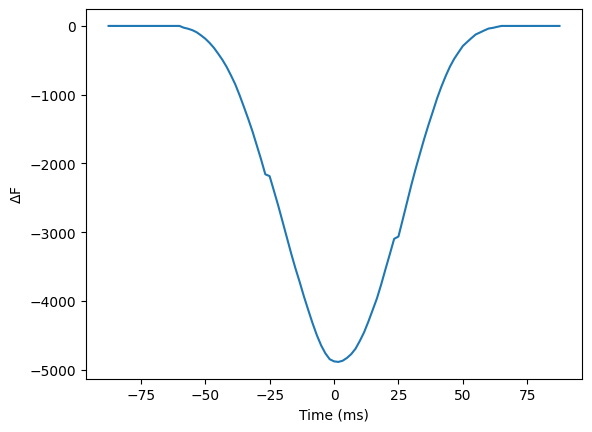

In [11]:
# Simulate at the corresponding vertex on the white matter surface
white_vertex = (n_layers-1)*verts_per_surf+sim_vertex
prefix = f'sim_{sim_vertex}_white_'

# Generate simulated data
white_sim_fname = run_dipole_simulation(
    base_fname, 
    prefix, 
    white_vertex, 
    sim_signal, 
    pial_unit_norm, 
    dipole_moment, 
    sim_patch_size, 
    SNR,
    spm_instance=spm
) 

# Localizer
[_,_,MU] = invert_ebb(
    multilayer_mesh_fname, 
    white_sim_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    return_mu_matrix=True,
    spm_instance=spm
)

layer_vertices = np.arange(verts_per_surf)
layer_ts, time, _ = load_source_time_series(
    white_sim_fname, 
    mu_matrix=MU, 
    vertices=layer_vertices
)

# Layer peak
m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
prior = np.argmax(m_layer_max)
prior_coord = ds_inflated.darrays[0].data[prior,:]

print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')
print('Simulated coordinate')
print(sim_coord)
print('Prior coordinate')
print(prior_coord)

# Run sliding time window model comparison between the first layer (pial) and the last layer (white matter)
[Fs,wois] = sliding_window_model_comparison(
    prior, 
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    [layer_fnames[0], layer_fnames[-1]], 
    white_sim_fname, 
    spm_instance=spm,
    invert_kwargs={
        'patch_size': patch_size, 
        'n_temp_modes': sliding_n_temp_modes,
        'win_size': win_size, 
        'win_overlap': win_overlap,
    }
)

# Plot difference in free energy over time (pial minus white) - this should be negative
plt.plot(np.mean(wois,axis=-1), Fs[0,:]-Fs[1,:])
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')

## Simulation in each layer with sliding time window model comparison across layers
That was sliding time window model comparison with two candidate models: one based on the white matter surface, and one on the pial. Let's now simulate on each layer, and for each simulation, run sliding time window model comparison across all layers. We'll turn off SPM visualization here.

In [ ]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, run sliding window model 
# comparison across all layers
all_layerF = []
for l in range(n_layers):
    print(f'Simulating in layer {l}')
    l_vertex = l*verts_per_surf+sim_vertex
    prefix = f'sim_{sim_vertex}{l}_'
    
    l_sim_fname = run_dipole_simulation(
        base_fname, 
        prefix, 
        l_vertex, 
        sim_signal, 
        pial_unit_norm, 
        dipole_moment, 
        sim_patch_size, 
        SNR, 
        spm_instance=spm
    ) 
    
    # Localizer
    [_,_,MU] = invert_ebb(
        multilayer_mesh_fname, 
        l_sim_fname, 
        n_layers, 
        patch_size=patch_size, 
        n_temp_modes=n_temp_modes,
        return_mu_matrix=True,
        viz=False,
        spm_instance=spm
    )

    layer_vertices = np.arange(verts_per_surf)
    layer_ts, time, _ = load_source_time_series(
        l_sim_fname, 
        mu_matrix=MU, 
        vertices=layer_vertices
    )

    # Layer peak
    m_layer_max = np.max(np.mean(layer_ts,axis=-1),-1)
    prior = np.argmax(m_layer_max)    
    prior_coord = ds_inflated.darrays[0].data[prior,:]

    print(f'Simulated vertex={sim_vertex}, Prior vertex={prior}')
    print('Simulated coordinate')
    print(sim_coord)
    print('Prior coordinate')
    print(prior_coord)

    [Fs,wois] = sliding_window_model_comparison(
        prior, 
        nas, 
        lpa, 
        rpa, 
        mri_fname, 
        layer_fnames, 
        l_sim_fname, 
        viz=False,
        spm_instance=spm,
        invert_kwargs={
            'patch_size': patch_size, 
            'n_temp_modes': sliding_n_temp_modes,
            'win_size': win_size, 
            'win_overlap': win_overlap,
        }
    )
    
    all_layerF.append(Fs)
all_layerF = np.squeeze(np.array(all_layerF))

For each simulation, we can plot the free energy for all models relative to the worst model within a central time window. The layer model with the highest free energy should correspond to the layer that the activity was simulated in.

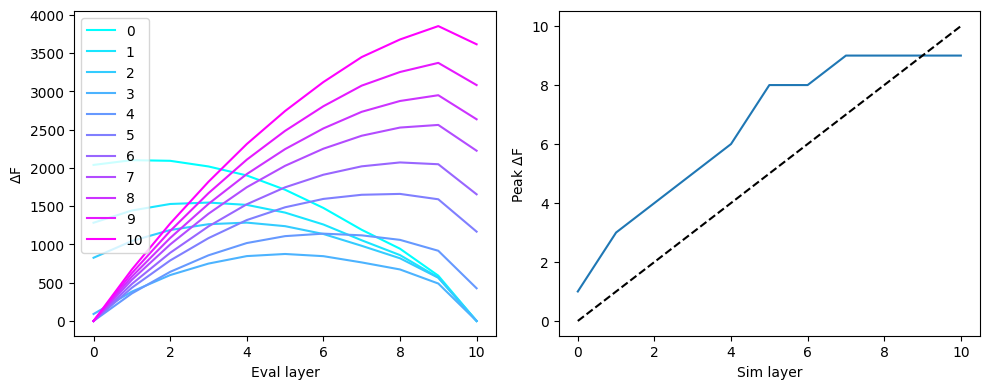

In [13]:
# Average free energy within small time window in center of the epoch
woi_t = np.mean(wois,axis=-1)
woi_idx = np.where((woi_t>=-20) & (woi_t<=20))[0]
m_all_layerF = np.mean(all_layerF[:,:,woi_idx],axis=2)

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))

# For each simulation, plot the mean free energy of each layer model relative to that of the worst
# model for that simulation
plt.subplot(1,2,1)
for l in range(n_layers):
    layerF = m_all_layerF[l,:]
    plt.plot(layerF-np.min(layerF), label=f'{l}', color=col_r[l,:])
plt.legend()
plt.xlabel('Eval layer')
plt.ylabel(r'$\Delta$F')

# For each simulation, find which layer model had the greatest free energy
plt.subplot(1,2,2)
peaks=[]
for l in range(n_layers):
    layerF = m_all_layerF[l,:]
    layerF = layerF-np.min(layerF)
    pk = np.argmax(layerF)
    peaks.append(pk)
plt.plot(peaks)
plt.xlim([-0.5,10.5])
plt.ylim([-0.5,10.5])
plt.plot([0,10],[0,10],'k--')
plt.xlabel('Sim layer')
plt.ylabel(r'Peak $\Delta$F')
plt.tight_layout()

In [14]:
spm.terminate()

# Delete simulation files

# Iterate over all items in the directory
for item in os.listdir(tmp_dir):
    item_path = os.path.join(tmp_dir, item)

    # Check if it's a file or a directory
    if os.path.isfile(item_path):
        # Delete the file
        os.remove(item_path)
    elif os.path.isdir(item_path):
        # Recursively delete the directory
        shutil.rmtree(item_path)